**1 тестовый пример. Сопло Лаваля**

In [ ]:
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina', 'pdf')
plt.rcParams['figure.dpi'] = 100

In [ ]:
import numpy as np

def NormMatrix(a):
    res = 0

    '''for i in range(len(a)):
        for j in range(len(a[0])):
            res += a[i][j]**2'''

    for i in range(len(a)):
        sum = 0
        for j in range(len(a[0])):
            sum += abs(a[i][j])
        res = max(res, sum)

    return res

def NormVector(a):
    res = 0

    for i in range(len(a)):
        res += a[i]**4

    return res**(0.25)

def MatrixDifference(a,b):
    res = np.empty(len(a), dtype=float)

    for i in range(len(a)):
        res[i] = a[i] - b[i]

    return res

def MatrixSum(a, b):
    res = np.empty(len(a), dtype=float)

    for i in range(len(a)):
        res[i] = a[i] + b[i]

    return res

def MatrixMultiplication(alpha, x, beta):
    res = np.empty(len(x), dtype=float)
    res = np.copy(x)

    for i in range(len(x)):
        res[i] = beta[i]
        for j in range(i):
            res[i] += alpha[i][j]*res[j]
        for j in range(i, len(x)):
            res[i] += alpha[i][j]*x[j]

    return res

def SimpleIterationsMethod(matrix, b, eps):
    size = len(matrix)

    alpha = np.zeros_like(matrix, dtype=float)
    beta = np.zeros_like(b, dtype=float)

    for i in range(size):
        for j in range(size):
            if i==j:
                alpha[i][j] = 0
            else:
                alpha[i][j] = -matrix[i][j]/matrix[i][i]
        #beta[0][i] = b[0][i]/matrix[i][i]
        beta[i] = b[i]/matrix[i][i]

    iterations_count = 0
    current_ans = np.copy(beta)
    normAlpha = NormMatrix(alpha)
    current_eps = 0

    while True:
        prev_ans = np.copy(current_ans)

        for i in range(size):
            res = beta[i]
            for j in range(size):
                res+=alpha[i][j]*prev_ans[j]
            current_ans[i] = res

        iterations_count+=1

        if normAlpha < 1:
            current_eps = (normAlpha/(1-normAlpha))*NormVector(MatrixDifference(current_ans, prev_ans))
        elif normAlpha == 1:
            current_eps = NormVector(MatrixDifference(current_ans, prev_ans))

        if current_eps <= eps:
            return current_ans, iterations_count

def ZeidelMethod(matrix, b, eps):
    size = len(matrix)

    alpha = np.zeros_like(matrix, dtype=float)
    beta = np.zeros_like(b, dtype=float)

    for i in range(size):
        for j in range(size):
            if i == j:
                alpha[i][j] = 0
            else:
                alpha[i][j] = -matrix[i][j] / matrix[i][i]
        # beta[0][i] = b[0][i]/matrix[i][i]
        beta[i] = b[i] / matrix[i][i]

    iterations_count = 0
    current_ans = np.copy(beta)
    normAlpha = NormMatrix(alpha)
    current_eps = 0

    while True:
        prev_ans = np.copy(current_ans)
        current_ans = MatrixMultiplication(alpha, prev_ans, beta)
        iterations_count += 1

        if normAlpha < 1:
            current_eps = (normAlpha/(1-normAlpha))*NormVector(MatrixDifference(current_ans, prev_ans))
        elif normAlpha == 1:
            current_eps = NormVector(MatrixDifference(current_ans, prev_ans))

        if current_eps <= eps:
            return current_ans, iterations_count

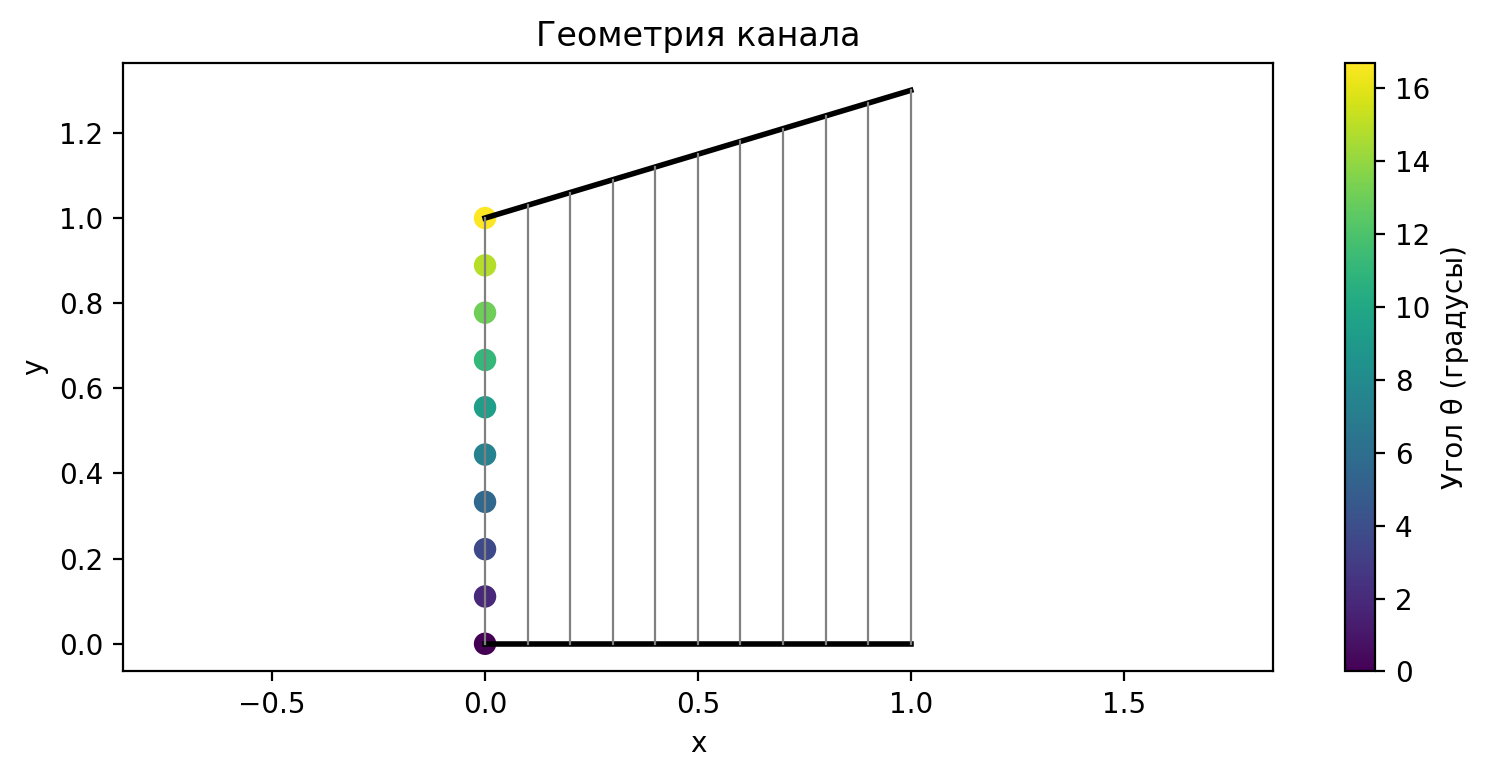

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def top_wall(x):
    return h0 + (h1 - h0)*(x/L)

# Геометрия канала
#L, h0, h1 = 3.0, 1.0, 4.0
L, h0, h1 = 1.0, 1.0, 1.3
alpha = np.arctan((h1 - h0)/L)
alpha_deg = np.degrees(alpha)
#print(alpha_deg)

num_layers = 10
num_points = 10
x_layers = np.linspace(0, L, num_layers+1)


x0 = 0.0
y0 = np.linspace(0, top_wall(x0), num_points)


theta0_deg = np.linspace(0, alpha_deg, num_points)

plt.figure(figsize=(8,4))
x_wall = np.linspace(0, L, 200)
plt.plot(x_wall, np.zeros_like(x_wall), 'k-', lw=2)
plt.plot(x_wall, top_wall(x_wall), 'k-', lw=2)

for xi in x_layers:
    plt.plot([xi, xi], [0, top_wall(xi)], color='gray', lw=0.8)

sc = plt.scatter(np.full(num_points, x0), y0, c=theta0_deg,
                 cmap='viridis', s=50)
plt.colorbar(sc, label='Угол θ (градусы)')

plt.title(f'Геометрия канала')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def top_wall(x):
    return h0 + (h1 - h0) * (x / L)

def sound_speed(p_, rho_):
    p_clamped   = np.maximum(p_,   eps)
    rho_clamped = np.maximum(rho_, eps)

    return np.sqrt(gamma * p_clamped / rho_clamped)

def enthalpy(p_, rho_):
    return gamma/(gamma-1) * p_ / np.maximum(rho_, eps)

def interp_y(field, yg, y_val):
    j = np.searchsorted(yg, y_val) - 1
    j = np.clip(j, 0, len(yg)-2)
    yj, yj1 = yg[j], yg[j+1]
    w1 = (yj1 - y_val) / (yj1 - yj + eps)
    w2 = (y_val - yj)   / (yj1 - yj + eps)

    return w1 * field[j] + w2 * field[j+1]

def compute_F(U, u_k_layer, v_k_layer, p_k_layer, rho_k_layer, yg, dx, y3):
    u3, v3, p3, rho3 = U

    theta3 = np.arctan2(v3, u3)
    w3 = np.hypot(u3, v3) + eps
    a3 = sound_speed(p3, rho3)
    mu3 = np.arcsin(np.clip(a3 / w3, -1.0, 1.0))

    lam_p = np.tan(theta3 + mu3)
    lam_m = np.tan(theta3 - mu3)
    lam_0 = v3 / (u3 + eps)

    y1 = y3 - lam_p * dx
    y2 = y3 - lam_m * dx
    y4 = y3 - lam_0 * dx

    u1, v1 = interp_y(u_k_layer,   yg, y1), interp_y(v_k_layer,   yg, y1)
    p1, rho1 = interp_y(p_k_layer, yg, y1), interp_y(rho_k_layer, yg, y1)
    u2, v2 = interp_y(u_k_layer,   yg, y2), interp_y(v_k_layer,   yg, y2)
    p2, rho2 = interp_y(p_k_layer, yg, y2), interp_y(rho_k_layer, yg, y2)
    u4, v4 = interp_y(u_k_layer,   yg, y4), interp_y(v_k_layer,   yg, y4)
    p4, rho4 = interp_y(p_k_layer, yg, y4), interp_y(rho_k_layer, yg, y4)

    a1, a2, a4 = sound_speed(p1, rho1), sound_speed(p2, rho2), sound_speed(p4, rho4)
    w1, w2, w4 = np.hypot(u1, v1)+eps, np.hypot(u2, v2)+eps, np.hypot(u4, v4)+eps
    mu1 = np.arcsin(np.clip(a1/w1, -1.0, 1.0))
    mu2 = np.arcsin(np.clip(a2/w2, -1.0, 1.0))
    cot1 = np.cos(mu1) / (np.sin(mu1) + eps)
    cot2 = np.cos(mu2) / (np.sin(mu2) + eps)

    F1 = theta3 - np.arctan2(v1, u1) + (1/(rho1*w1**2+eps))*cot1*(p3-p1)
    F2 = theta3 - np.arctan2(v2, u2) - (1/(rho2*w2**2+eps))*cot2*(p3-p2)
    F3 = p3 - p4 - a4**2*(rho3-rho4)
    F4 = enthalpy(p3,rho3) - enthalpy(p4,rho4) + 0.5*((u3**2+v3**2)-(u4**2+v4**2))

    return np.array([F1, F2, F3, F4])


#Параметры газа и канала

gamma, R = 1.4, 287.0
p_ref, T_ref, M_ref = 101325.0, 300.0, 2.0
a_ref = np.sqrt(gamma * R * T_ref)
w_ref = M_ref * a_ref
#print(p_ref / (R * T_ref))

L, h0, h1 = 1.0, 1.0, 1.3
alpha = np.arctan((h1 - h0)/L)

Nx, Ny = 50, 10
x = np.linspace(0, L, Nx+1)
y0 = np.linspace(0, top_wall(0), Ny)
theta0 = np.linspace(0, alpha, Ny)

u   = np.zeros((Nx+1, Ny))
v   = np.zeros((Nx+1, Ny))
p   = np.zeros((Nx+1, Ny))
rho = np.zeros((Nx+1, Ny))

u[0,:]   = w_ref * np.cos(theta0)
v[0,:]   = w_ref * np.sin(theta0)
p[0,:]   = p_ref
rho[0,:] = p_ref / (R * T_ref)

eps = 1e-8
max_iter = 10
tol = 1e-6
delta = 1e-6

#  Основной цикл с методом Ньютона
for k in range(Nx):
    dx = x[k+1] - x[k]
    yg  = np.linspace(0, top_wall(x[k]),   Ny)
    yg1 = np.linspace(0, top_wall(x[k+1]), Ny)

    for j in range(Ny):
        y3 = yg1[j]

        u_k_layer = u[k,:]; v_k_layer = v[k,:]
        p_k_layer = p[k,:]; rho_k_layer = rho[k,:]

        U = np.array([u[k,j], v[k,j], p[k,j], rho[k,j]])

        for n in range(max_iter):
            F = compute_F(U, u_k_layer, v_k_layer, p_k_layer, rho_k_layer, yg, dx, y3)
            J = np.zeros((4,4))

            for i in range(4):
                dU = np.zeros(4)
                dU[i] = delta
                J[:,i] = (compute_F(U + dU, u_k_layer, v_k_layer, p_k_layer, rho_k_layer, yg, dx, y3) - F) / delta

            try:
                dU = np.linalg.solve(J, -F)

            except np.linalg.LinAlgError:
                J_reg = J + np.eye(4)*1e-6

                try:
                    dU = np.linalg.solve(J_reg, -F)

                except np.linalg.LinAlgError:

                    dU = -np.linalg.pinv(J).dot(F)

            U_new = U + dU
            U_new[2] = max(U_new[2], eps)
            U_new[3] = max(U_new[3], eps)

            if np.linalg.norm(dU, np.inf) < tol:
                U = U_new
                break

            U = U_new

        u[k+1,j], v[k+1,j], p[k+1,j], rho[k+1,j] = U

Средние параметры:

Середина (x=0.500):
 <M> = 2.162716856624813
 <p> = 78671.55537564501 Па
 <T> = 279.0004225183971 К
 <rho> = 0.9824842494444314 кг/м³

Выход (x=1.000):
 <M> = 2.2958325387479475
 <p> = 63916.814499111555 Па
 <T> = 262.8767008364385 К
 <rho> = 0.8471643838090008 кг/м³


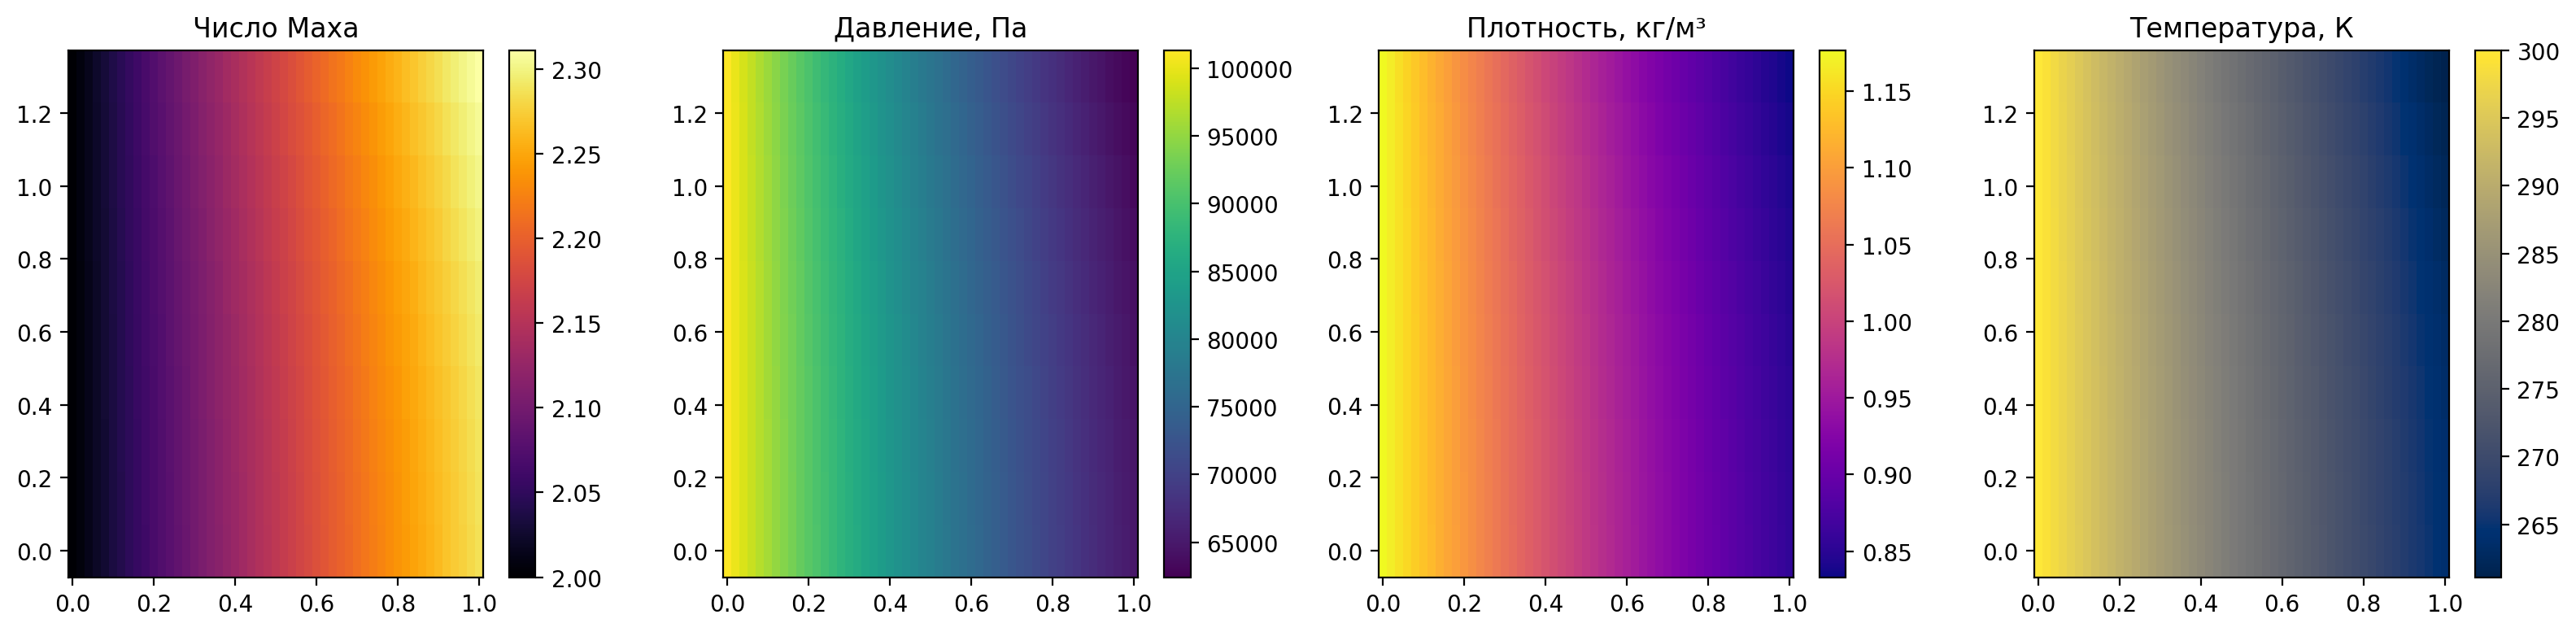

In [ ]:
T   = p / (rho * R)
a   = np.sqrt(gamma * p / rho)
M   = np.hypot(u, v) / a
w   = np.hypot(u, v)

# Средние по слою
mid_k  = Nx//2
exit_k = Nx
print("Средние параметры:")
for name, k in [("Середина", mid_k), ("Выход", exit_k)]:
    print(f"\n{name} (x={x[k]:.3f}):")
    print(" <M> =", np.mean(M[k,:]))
    print(" <p> =", np.mean(p[k,:]), "Па")
    print(" <T> =", np.mean(T[k,:]), "К")
    print(" <rho> =", np.mean(rho[k,:]), "кг/м³")

fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(16,4))

'''ax1.plot(x, np.zeros_like(x),'k-')
ax1.plot(x, top_wall(x),'k-')
ax1.set_title('Канал')
ax1.set_aspect('equal')'''

# Mach
c1 = ax1.pcolormesh(x, yg1, M.T, shading='auto', cmap='inferno')
fig.colorbar(c1,ax=ax1)
ax1.set_title('Число Маха')
# Pressure
c2 = ax2.pcolormesh(x, yg1, p.T, shading='auto', cmap='viridis')
fig.colorbar(c2,ax=ax2)
ax2.set_title('Давление, Па')
# Density
c3 = ax3.pcolormesh(x, yg1, rho.T, shading='auto', cmap='plasma')
fig.colorbar(c3,ax=ax3)
ax3.set_title('Плотность, кг/м³')
# Temperature
c4 = ax4.pcolormesh(x, yg1, T.T, shading='auto', cmap='cividis')
fig.colorbar(c4,ax=ax4)
ax4.set_title('Температура, К')

plt.tight_layout()
plt.show()

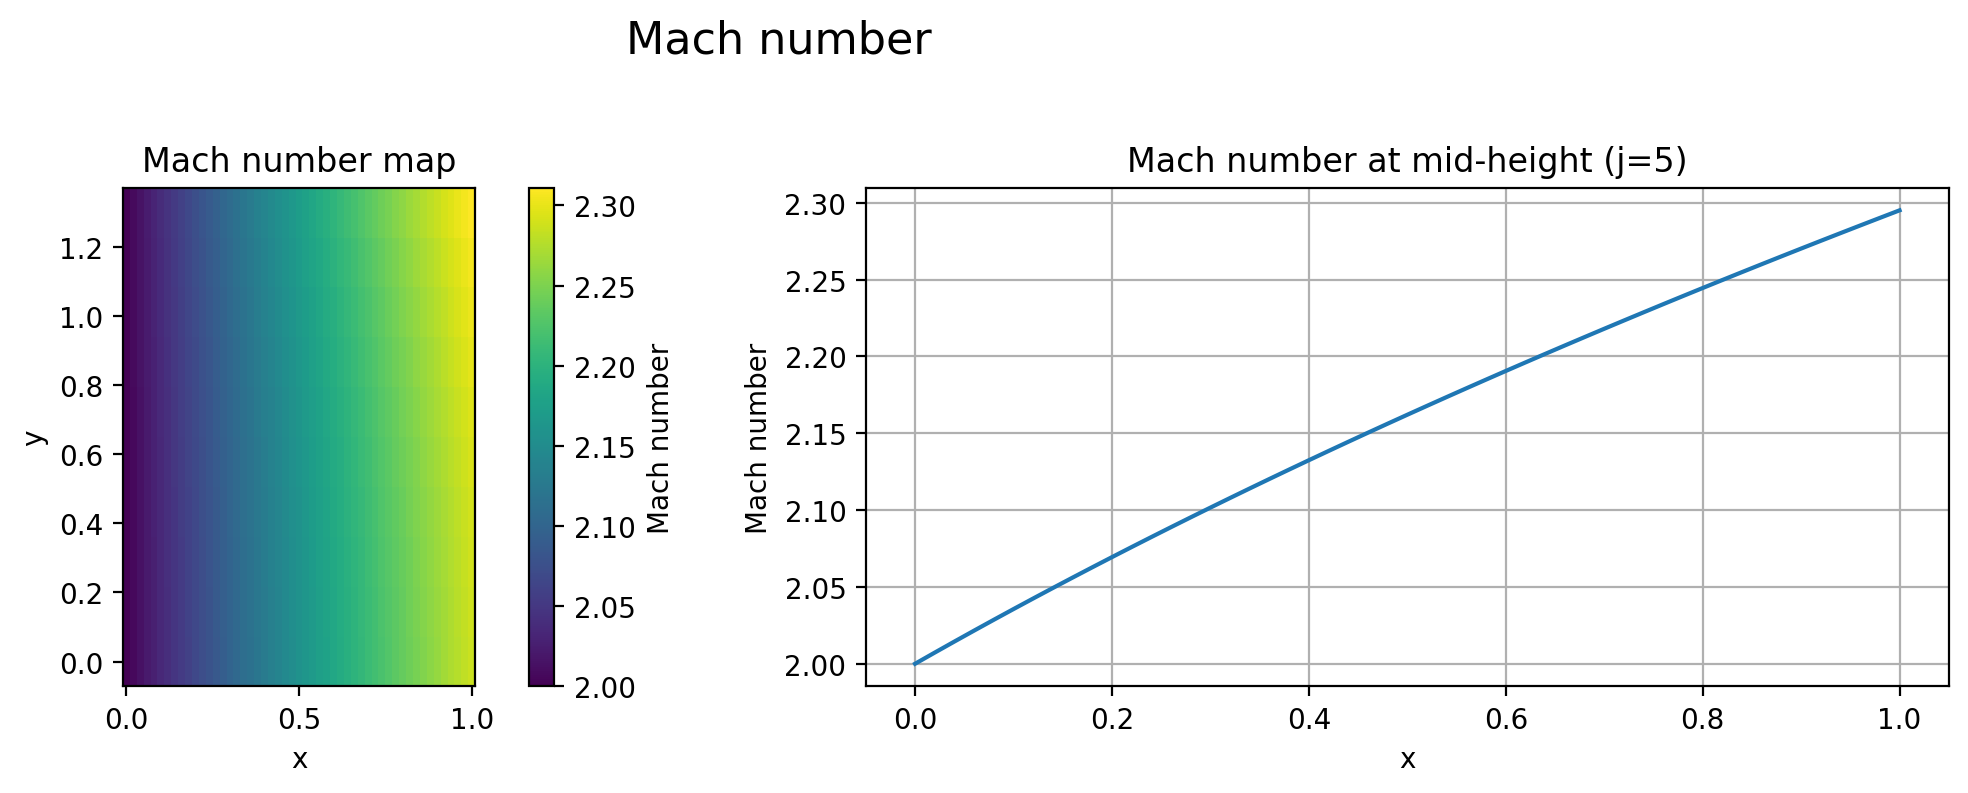

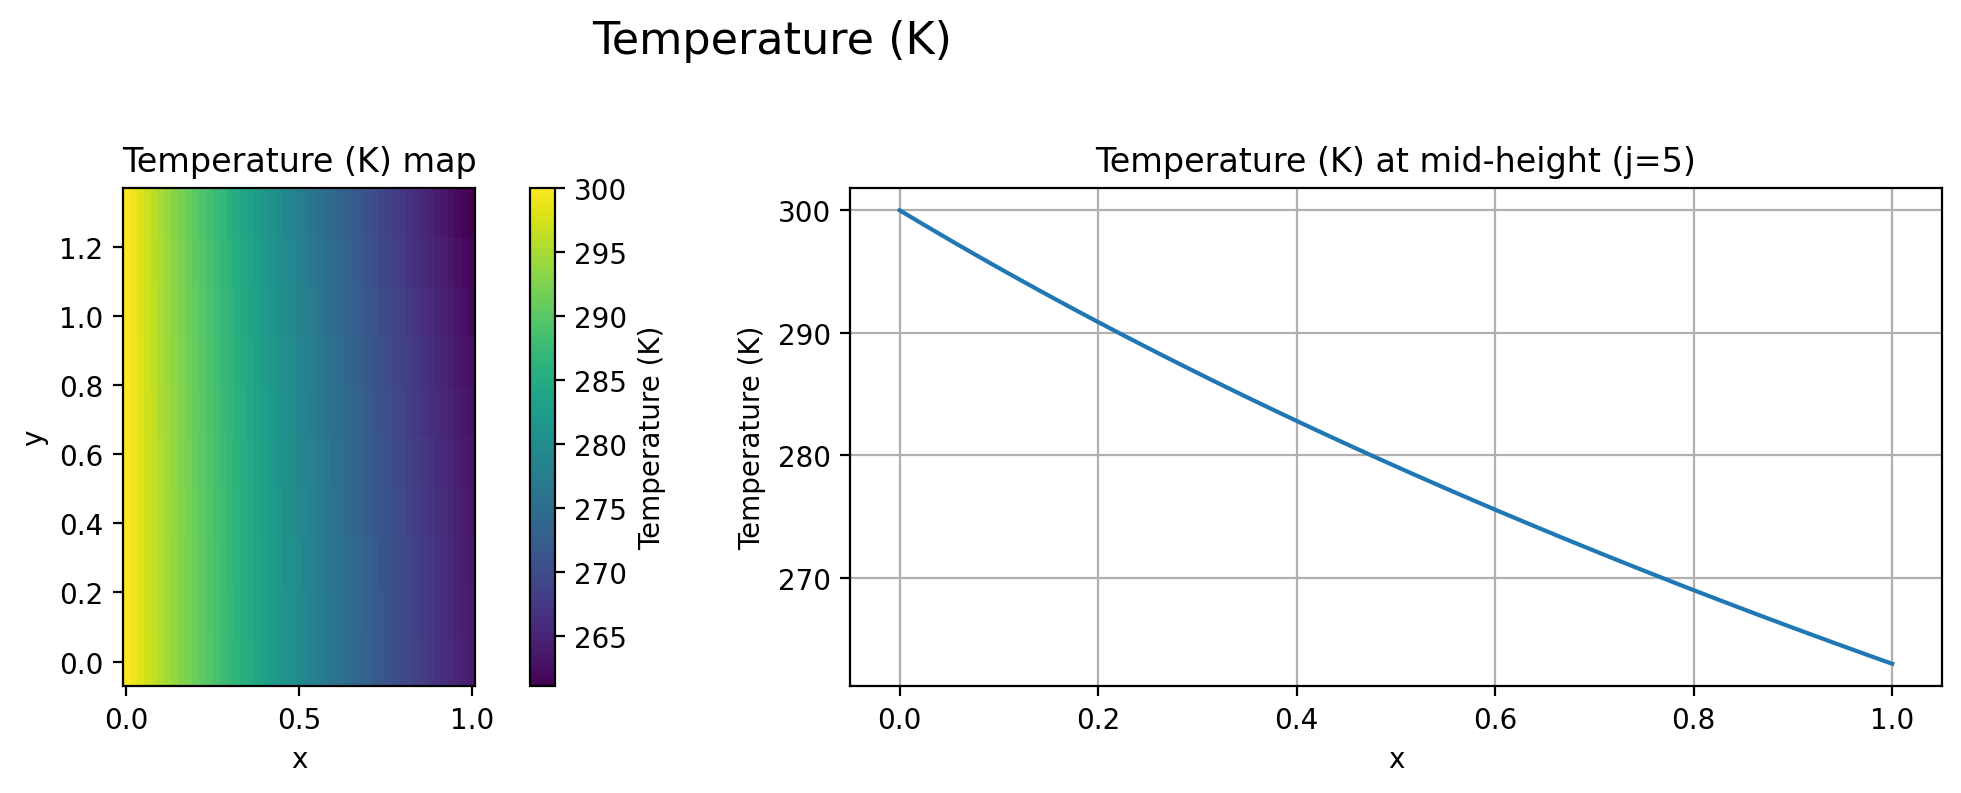

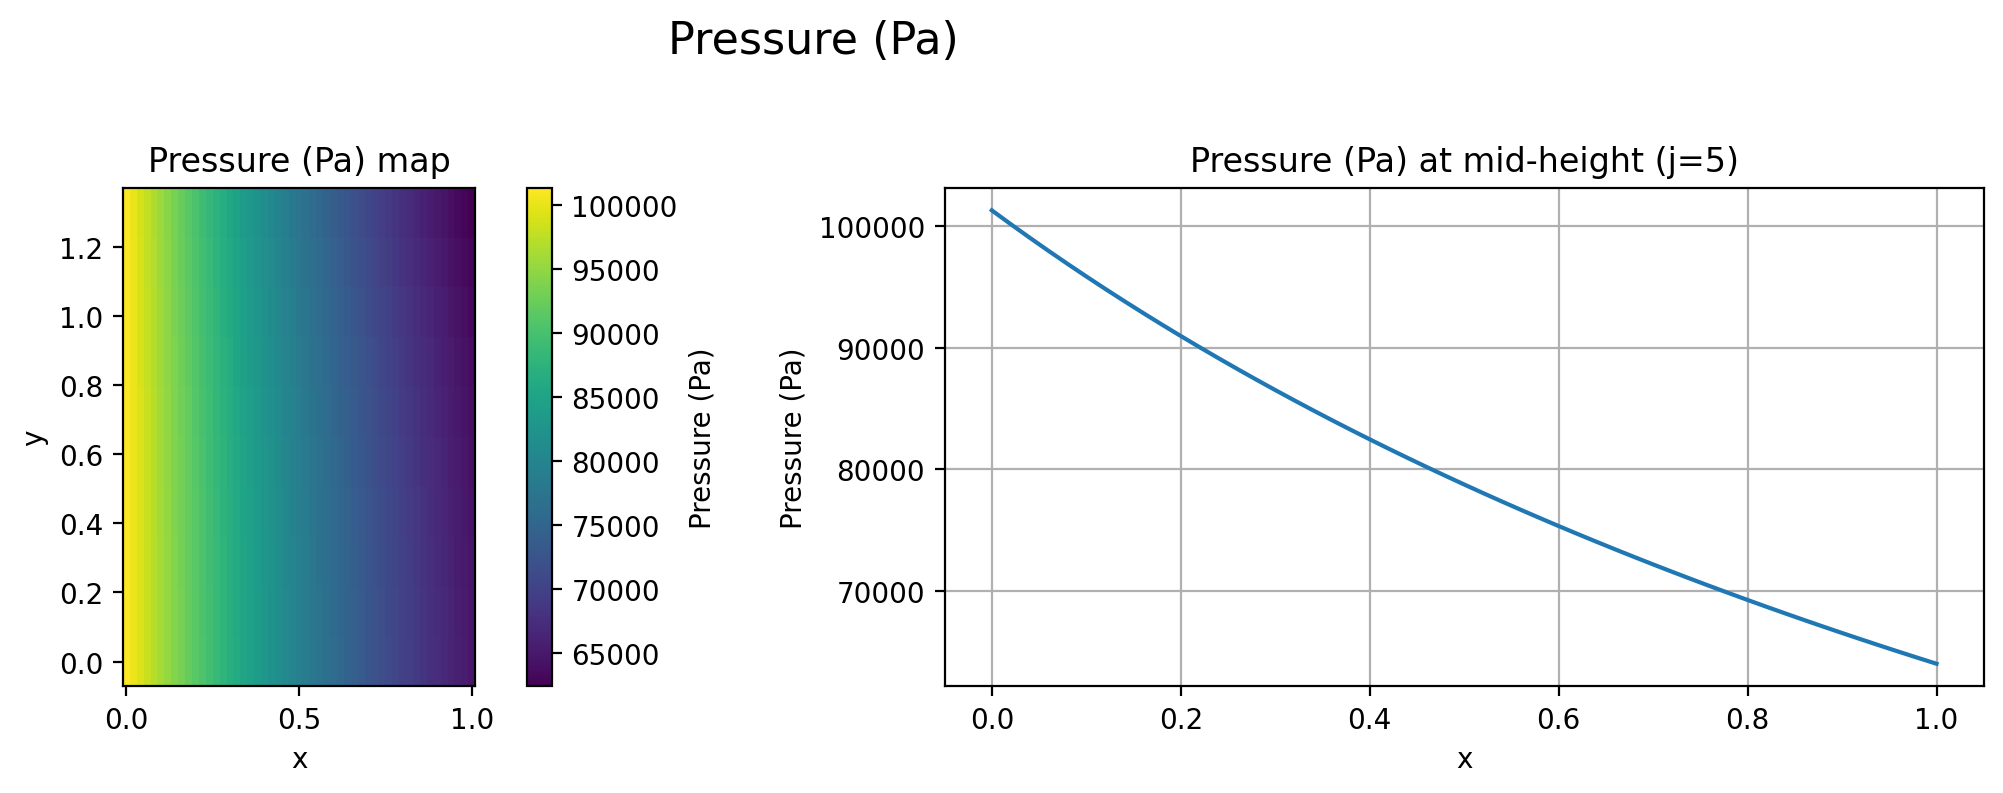

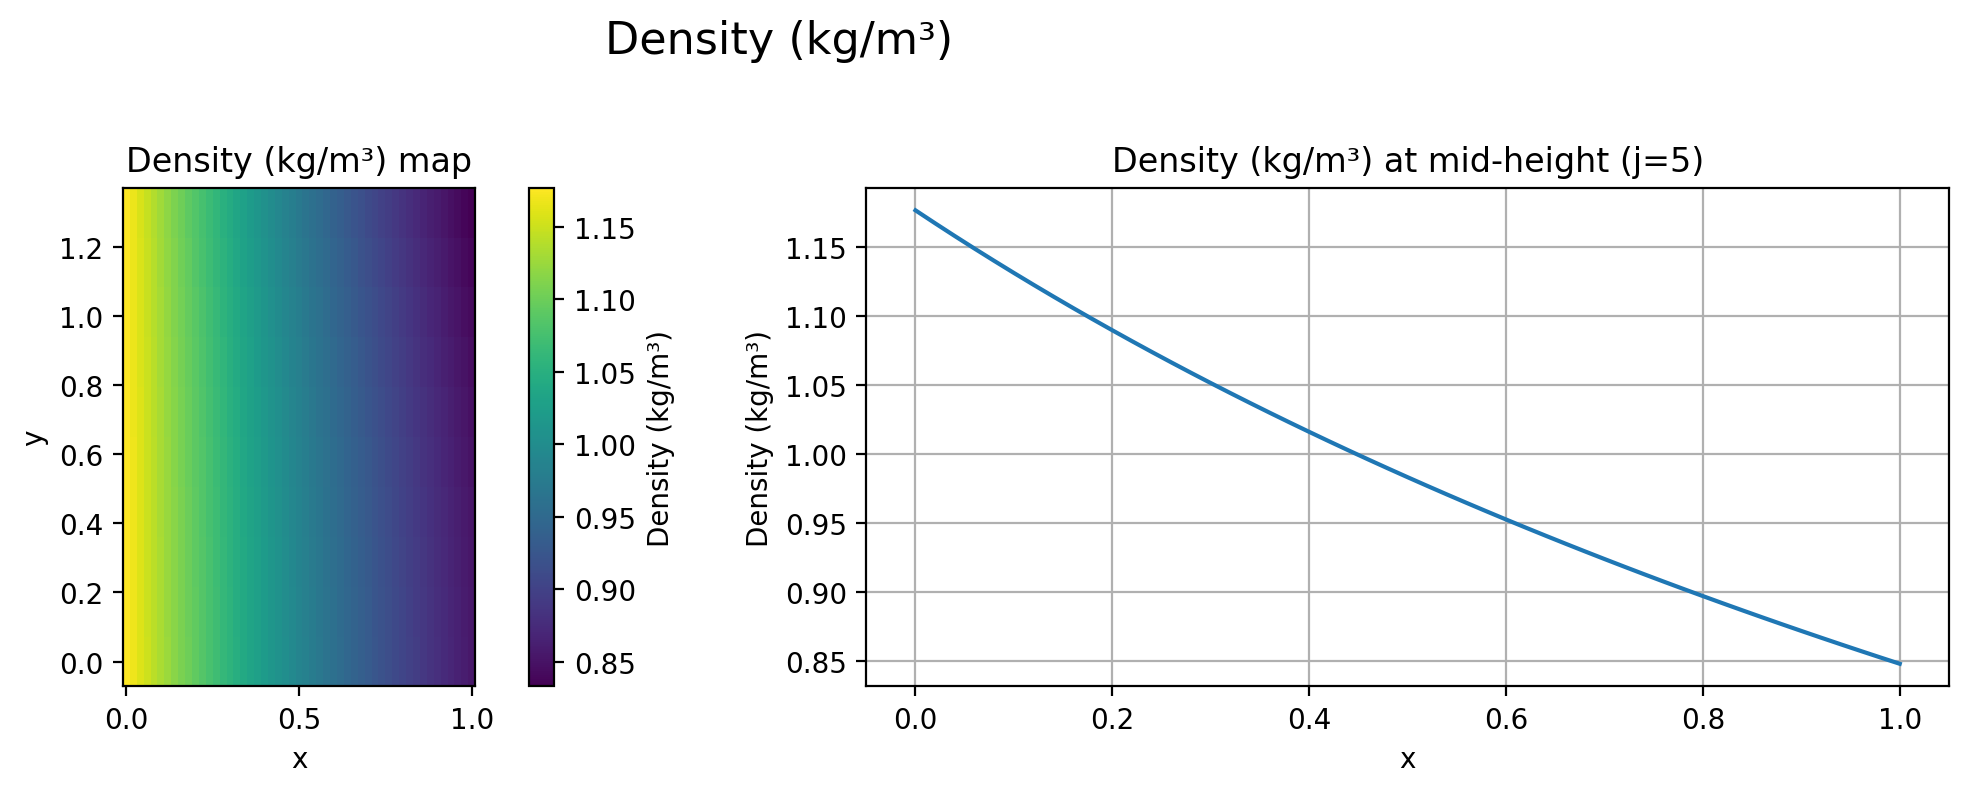

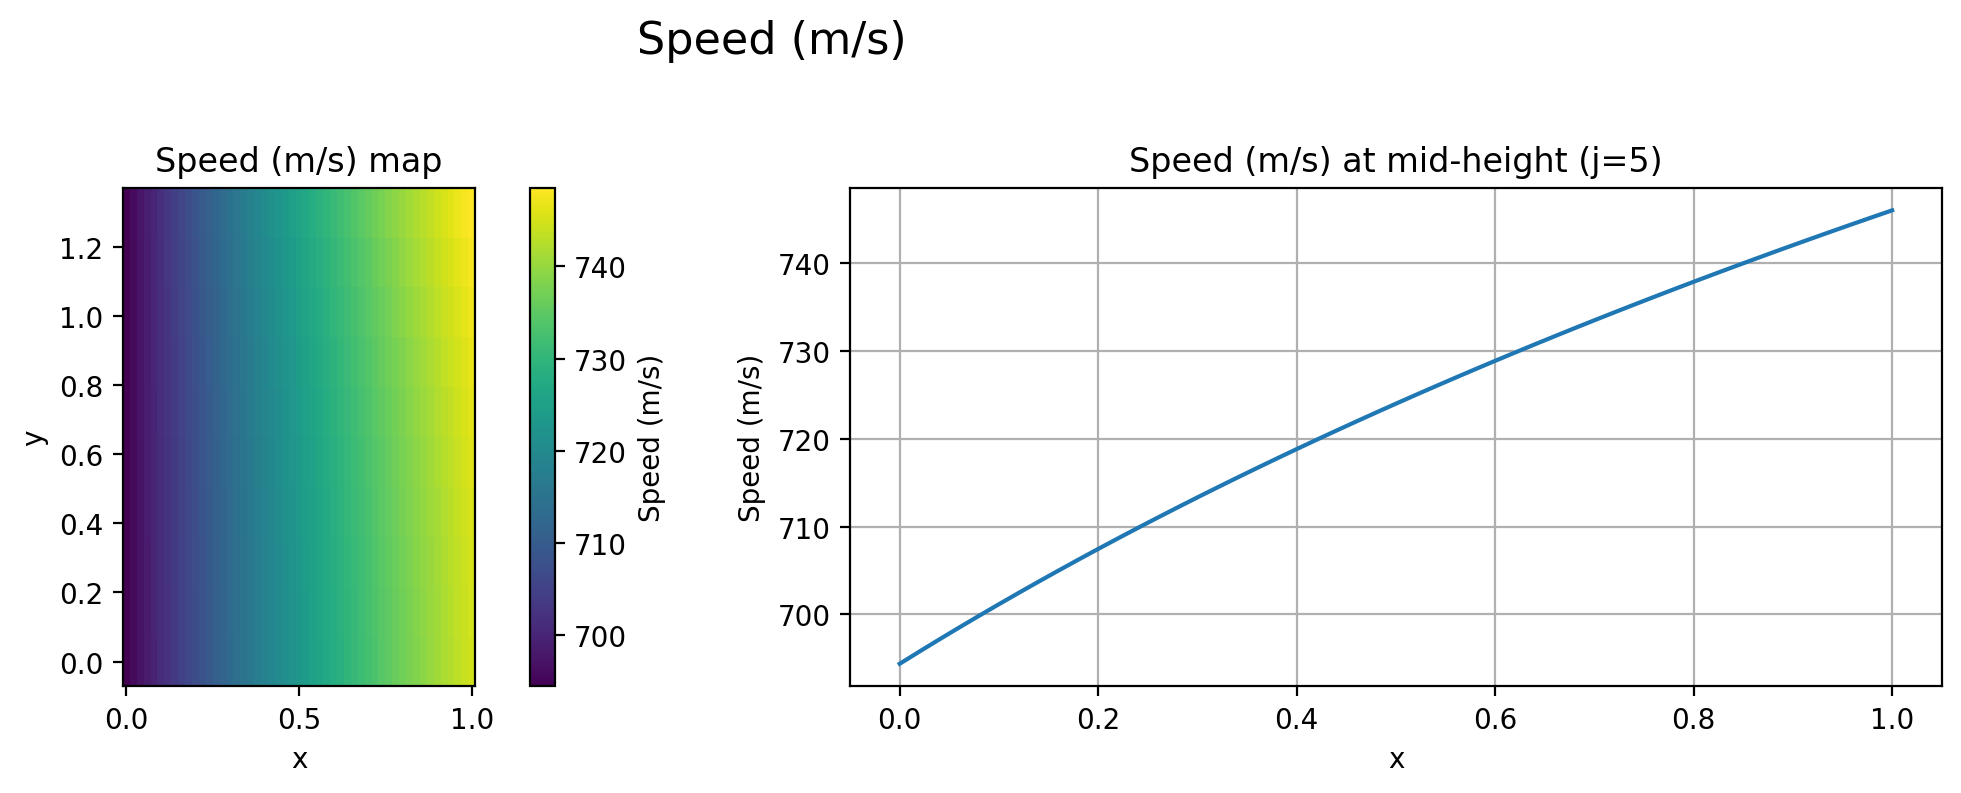

In [ ]:
fields = {
    "Mach number": (M, "M"),
    "Temperature (K)": (T, "T"),
    "Pressure (Pa)": (p, "p"),
    "Density (kg/m³)": (rho, "rho"),
    "Speed (m/s)": (w, "w")
}

j_mid = Ny // 2

for title, (field, var) in fields.items():
    mid_dist = field[:, j_mid]

    fig, (ax_map, ax_line) = plt.subplots(1, 2, figsize=(12, 4))


    c = ax_map.pcolormesh(x, yg1, field.T, shading='auto', cmap='viridis')
    fig.colorbar(c, ax=ax_map, label=title)
    ax_map.set_title(f"{title} map")
    ax_map.set_xlabel("x")
    ax_map.set_ylabel("y")
    ax_map.set_aspect('equal')

    ax_line.plot(x, mid_dist)
    ax_line.set_title(f"{title} at mid-height (j={j_mid})")
    ax_line.set_xlabel("x")
    ax_line.set_ylabel(title)
    ax_line.grid(True)

    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

**2 пример. Течение от источника**

In [ ]:
import math

# Возвращает (w, M, p, rho) для r ≥ r_star
def analytical_point_source(r,r_star = 1.0, p_star = 101325.0,
rho_star = 1.0, kappa = 1.4,tol = 1e-10, max_iter = 100):

    if r < r_star:
        raise ValueError("r должен быть ≥ r_star")

    a_star = math.sqrt(kappa * p_star / rho_star)
    target = r / r_star
    w_lo = a_star
    w_hi = a_star * math.sqrt((kappa+1)/(kappa-1)) * (1 - 1e-12)

    def F(w):
        A = (kappa+1)/2 - (kappa-1)/2 * (w**2 / a_star**2)

        return 1.0 / (A**(1.0/(kappa-1)) * (w/a_star)) - target

    f_lo = F(w_lo)
    f_hi = F(w_hi)

    if f_lo * f_hi > 0:
        raise RuntimeError("Корень не лежит в физическом диапазоне")

    for _ in range(max_iter):
        w_mid = 0.5*(w_lo + w_hi)
        f_mid = F(w_mid)

        if abs(f_mid) < tol or (w_hi - w_lo)/2 < tol:
            w = w_mid
            break

        if f_mid * f_lo < 0:
            w_hi = w_mid
        else:
            w_lo, f_lo = w_mid, f_mid
    else:
        raise RuntimeError("Бисекция не сошлась")


    A = (kappa+1)/2 - (kappa-1)/2 * (w**2 / a_star**2)
    a   = a_star * math.sqrt(A)
    M   = w / a
    rho = rho_star * A**(1.0/(kappa-1))
    p   = rho * a**2 / kappa

    return w, M, p, rho

In [ ]:
for r in [1.1, 2.6, 3.1, 5.0]:
        w, M, p, rho = analytical_point_source(r)
        print(f"r={r:.1f} → w={w:7.2f} м/с, M={M:5.3f}, p={p:8.1f} Па, rho={rho:6.4f} кг/м³")

r=1.1 → w= 482.46 м/с, M=1.372, p= 62691.4 Па, rho=0.7097 кг/м³
r=2.6 → w= 685.79 м/с, M=2.485, p= 11491.4 Па, rho=0.2112 кг/м³
r=3.1 → w= 707.52 м/с, M=2.672, p=  8599.4 Па, rho=0.1717 кг/м³
r=5.0 → w= 754.26 м/с, M=3.175, p=  4026.4 Па, rho=0.0999 кг/м³


45.0


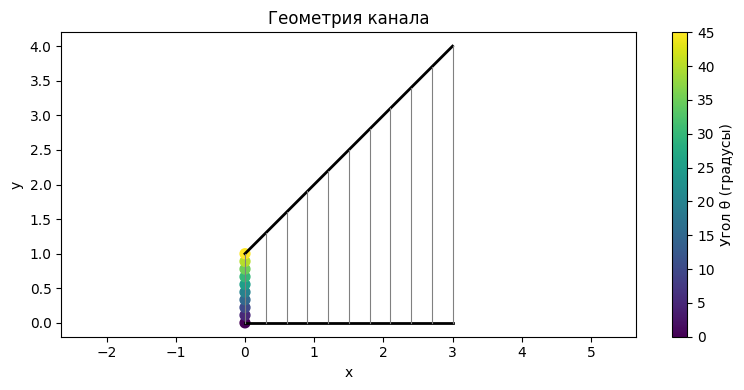

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Геометрия канала
L, h0, h1 = 3.0, 1.0, 4.0
#L, h0, h1 = 1.0, 1.0, 1.3
alpha = np.arctan((h1 - h0)/L)
alpha_deg = np.degrees(alpha)
print(alpha_deg)

def top_wall(x):
    return h0 + (h1 - h0)*(x/L)

num_layers = 10
num_points = 10
x_layers = np.linspace(0, L, num_layers+1)


x0 = 0.0
y0 = np.linspace(0, top_wall(x0), num_points)


theta0_deg = np.linspace(0, alpha_deg, num_points)

plt.figure(figsize=(8,4))
x_wall = np.linspace(0, L, 200)
plt.plot(x_wall, np.zeros_like(x_wall), 'k-', lw=2)
plt.plot(x_wall, top_wall(x_wall), 'k-', lw=2)

for xi in x_layers:
    plt.plot([xi, xi], [0, top_wall(xi)], color='gray', lw=0.8)

sc = plt.scatter(np.full(num_points, x0), y0, c=theta0_deg,
                 cmap='viridis', s=50)
plt.colorbar(sc, label='Угол θ (градусы)')

plt.title(f'Геометрия канала')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def top_wall(x):
      return h0 + (h1 - h0) * (x / L)

def sound_speed(p_, rho_):
        p_clamped   = np.maximum(p_,   eps)
        rho_clamped = np.maximum(rho_, eps)
        return np.sqrt(gamma * p_clamped / rho_clamped)

def enthalpy(p_, rho_):
    return gamma/(gamma-1) * p_ / np.maximum(rho_, eps)

def interp_y(field, yg, y_val):
    j = np.searchsorted(yg, y_val) - 1
    j = np.clip(j, 0, len(yg)-2)
    yj, yj1 = yg[j], yg[j+1]
    w1 = (yj1 - y_val) / (yj1 - yj + eps)
    w2 = (y_val - yj)   / (yj1 - yj + eps)

    return w1 * field[j] + w2 * field[j+1]


def compute_F(U, u_k_layer, v_k_layer, p_k_layer, rho_k_layer, yg, dx, y3):
    A_max = 1e6
    u3, v3, p3, rho3 = U

    p3   = np.clip(p3,   eps, None)
    rho3 = np.clip(rho3, eps, None)

    theta3 = np.arctan2(v3, u3)
    w3 = np.hypot(u3, v3) + eps
    a3 = sound_speed(p3, rho3)
    mu3 = np.arcsin(np.clip(a3 / w3, -1.0, 1.0))

    lam_p = np.tan(theta3 + mu3)
    lam_m = np.tan(theta3 - mu3)
    lam_0 = v3 / (u3 + eps)

    y1 = y3 - lam_p * dx
    y2 = y3 - lam_m * dx
    y4 = y3 - lam_0 * dx

    u1, v1 = interp_y(u_k_layer,   yg, y1), interp_y(v_k_layer,   yg, y1)
    p1, rho1 = interp_y(p_k_layer, yg, y1), interp_y(rho_k_layer, yg, y1)
    u2, v2 = interp_y(u_k_layer,   yg, y2), interp_y(v_k_layer,   yg, y2)
    p2, rho2 = interp_y(p_k_layer, yg, y2), interp_y(rho_k_layer, yg, y2)
    u4, v4 = interp_y(u_k_layer,   yg, y4), interp_y(v_k_layer,   yg, y4)
    p4, rho4 = interp_y(p_k_layer, yg, y4), interp_y(rho_k_layer, yg, y4)

    p4   = np.clip(p4,   eps, None)
    rho4 = np.clip(rho4, eps, None)

    a1, a2, a4 = sound_speed(p1, rho1), sound_speed(p2, rho2), sound_speed(p4, rho4)
    w1, w2, w4 = np.hypot(u1, v1)+eps, np.hypot(u2, v2)+eps, np.hypot(u4, v4)+eps
    mu1 = np.arcsin(np.clip(a1/w1, -1.0, 1.0))
    mu2 = np.arcsin(np.clip(a2/w2, -1.0, 1.0))
    cot1 = np.cos(mu1) / (np.sin(mu1) + eps)
    cot2 = np.cos(mu2) / (np.sin(mu2) + eps)

    F1 = theta3 - np.arctan2(v1, u1) + (1/(rho1*w1**2+eps))*cot1*(p3-p1)
    F2 = theta3 - np.arctan2(v2, u2) - (1/(rho2*w2**2+eps))*cot2*(p3-p2)
    F3 = p3 - p4 - a4**2*(rho3-rho4)

    h3 = enthalpy(p3, rho3)
    h4 = enthalpy(p4, rho4)
    dh = np.clip(h3 - h4, -A_max, A_max)
    dv2 = 0.5*((u3**2+v3**2)-(u4**2+v4**2))
    dv2 = np.clip(dv2, -A_max, A_max)

    F4 = dh + dv2

    #F4 = enthalpy(p3,rho3) - enthalpy(p4,rho4) + 0.5*((u3**2+v3**2)-(u4**2+v4**2))
    return np.array([F1, F2, F3, F4])

def run_schm(gamma, R, p_ref, rho_ref, M_ref, L, h0, h1, Nx, Ny, max_iter = 10,
tol = 1e-6, delta = 1e-6, M_max = 5.0, eps = 1e-8):

    T_ref = p_ref / (R * rho_ref)
    a_ref = np.sqrt(gamma * R * T_ref)
    w_ref = M_ref * a_ref
    #print(w_ref)

    alpha = np.arctan((h1 - h0)/L)

    x = np.linspace(0, L, Nx+1)
    y0 = np.linspace(0, top_wall(0), Ny)
    theta0 = np.linspace(0, alpha, Ny)

    u   = np.zeros((Nx+1, Ny))
    v   = np.zeros((Nx+1, Ny))
    p   = np.zeros((Nx+1, Ny))
    rho = np.zeros((Nx+1, Ny))

    u[0,:]   = w_ref * np.cos(theta0)
    v[0,:]   = w_ref * np.sin(theta0)
    p[0,:]   = p_ref
    rho[0,:] = p_ref / (R * T_ref)


    eps = 1e-8
    A_max = 1e6
    max_iter = 10
    tol = 1e-6
    delta = 1e-6

    for k in range(Nx):
        dx = x[k+1] - x[k]
        yg  = np.linspace(0, top_wall(x[k]),   Ny)
        yg1 = np.linspace(0, top_wall(x[k+1]), Ny)

        for j in range(Ny):
            y3 = yg1[j]

            u_k_layer = u[k,:]
            v_k_layer = v[k,:]
            p_k_layer = p[k,:]
            rho_k_layer = rho[k,:]

            U = np.array([u[k,j], v[k,j], p[k,j], rho[k,j]])

            for n in range(max_iter):
                F = compute_F(U, u_k_layer, v_k_layer, p_k_layer, rho_k_layer, yg, dx, y3)

                if not np.all(np.isfinite(F)):
                  break

                J = np.zeros((4,4))
                for i in range(4):
                    dU = np.zeros(4)
                    dU[i] = delta
                    Fi = compute_F(U + dU, u_k_layer, v_k_layer, p_k_layer, rho_k_layer, yg, dx, y3)
                    J[:,i] = (Fi - F) / delta

                try:
                    dU = np.linalg.solve(J, -F)
                except np.linalg.LinAlgError:

                    J_reg = J + np.eye(4)*1e-6
                    try:
                        dU = np.linalg.solve(J_reg, -F)
                    except np.linalg.LinAlgError:

                        dU = -np.linalg.pinv(J).dot(F)
                #dU = np.linalg.solve(J, -F)
                #dU, _ = ZeidelMethod(J, -F, tol)
                U_new = U + dU
                U_new[2] = max(U_new[2], eps)
                U_new[3] = max(U_new[3], eps)

                w_new = np.hypot(U_new[0], U_new[1])
                a_new = sound_speed(U_new[2], U_new[3])
                M_new = w_new / (a_new + eps)
                M_max = 5.0

                if M_new > M_max:
                    scale = (M_max * a_new) / (w_new + eps)
                    U_new[0] *= scale
                    U_new[1] *= scale

                if np.linalg.norm(dU, np.inf) < tol:
                    U = U_new
                    break
                U = U_new


            u[k+1,j], v[k+1,j], p[k+1,j], rho[k+1,j] = U


    T   = p/(rho*R)
    a   = np.sqrt(gamma*p/rho)
    w   = np.hypot(u,v)
    M   = w/a

    fields = dict(u=u, v=v, p=p, rho=rho, T=T, a=a, w=w, M=M)
    '''fields = {
    "Mach number": (M, "M"),
    "Temperature (K)": (T, "T"),
    "Pressure (Pa)": (p, "p"),
    "Density (kg/m³)": (rho, "rho"),
    "Speed (m/s)": (w, "w")
    }'''

    return x, yg1, fields

# Пример использования
if __name__=="__main__":
    x, yg1, f = run_schm(
        gamma=1.4, R=287, p_ref=62691.4, rho_ref=0.7097, M_ref=1.372,
        L=3.0, h0=1.0, h1=4.0, Nx=50, Ny=10
    )
    # Вывод средних по слою:
    mid, end = len(x)//2, -1
    print("Средние в середине канала:", np.mean(f['M'][mid,len(yg1)//2]), np.mean(f['p'][mid,len(yg1)//2]))
    print("Средние на выходе       :", np.mean(f['M'][end,:]), np.mean(f['p'][end,:]))


Средние в середине канала: 2.876396136718826 6744.207840519944
Средние на выходе       : 3.95923789129073 3414.812000009662


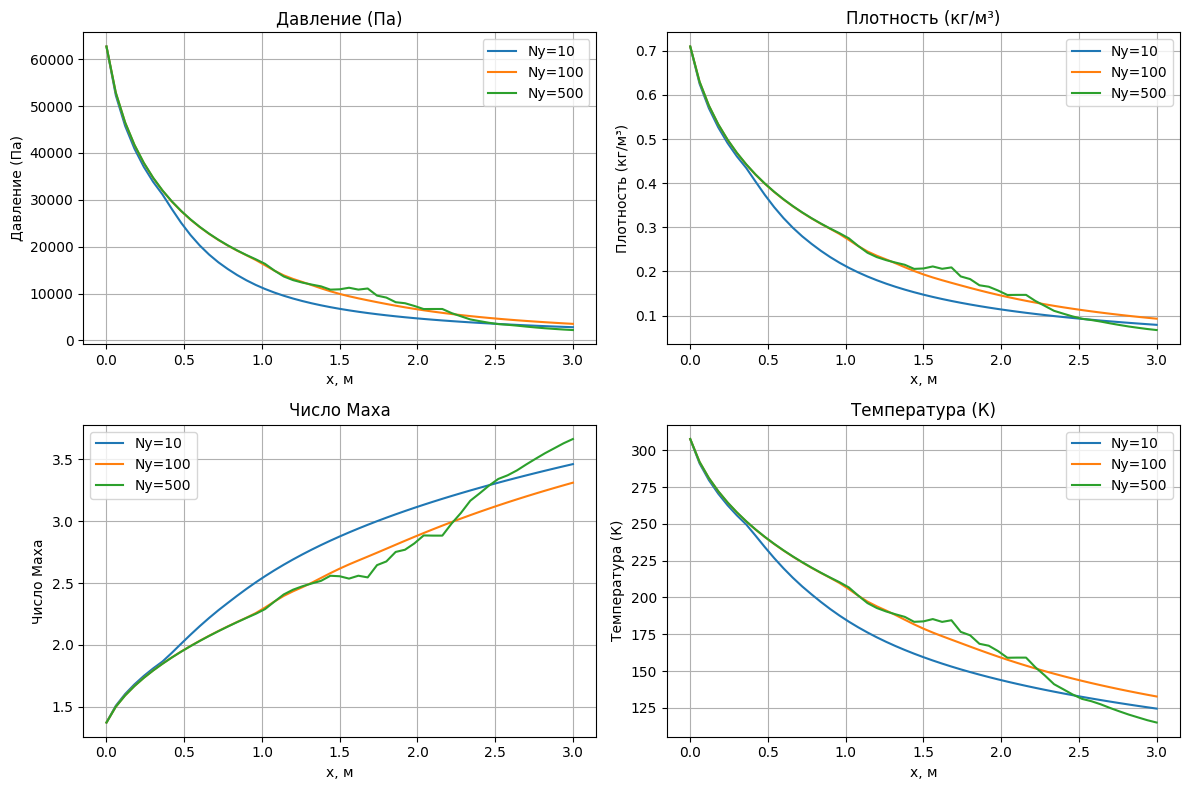

In [ ]:
Ny_list = [10,100, 500]
results = {}
for Ny in Ny_list:
    x, y_grid, fields = run_schm(
        gamma=1.4, R=287,
        p_ref=62691.4, rho_ref=0.7097, M_ref=1.372,
        L=3.0, h0=1.0, h1=4.0,
        Nx=50, Ny=Ny
    )
    results[Ny] = (x, y_grid, fields)

mid_plots = ['p', 'rho', 'M', 'T']
titles = {'p': 'Давление (Па)', 'rho': 'Плотность (кг/м³)', 'M': 'Число Маха', 'T': 'Температура (К)'}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for idx, param in enumerate(mid_plots):
    ax = axes[idx]
    for Ny in Ny_list:
        x, y_grid, fields = results[Ny]
        mid = len(y_grid) // 2
        ax.plot(x, fields[param][:, mid], label=f'Ny={Ny}')
    ax.set_title(titles[param])
    ax.set_xlabel('x, м')
    ax.set_ylabel(titles[param])
    ax.grid(True)
    ax.legend()
plt.tight_layout()
plt.show()



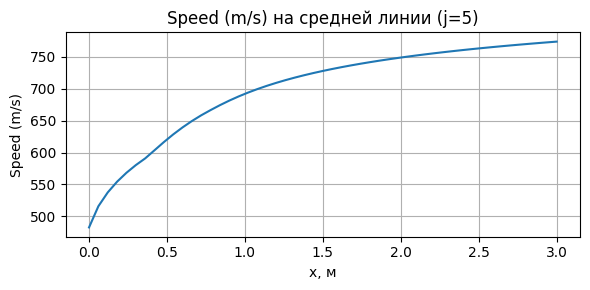

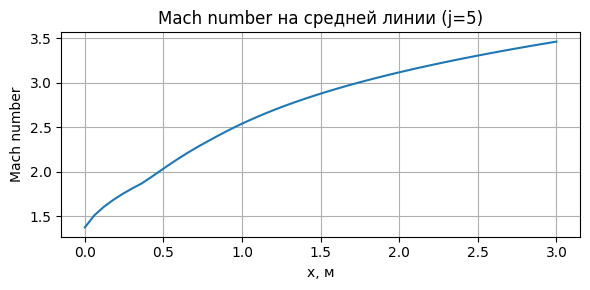

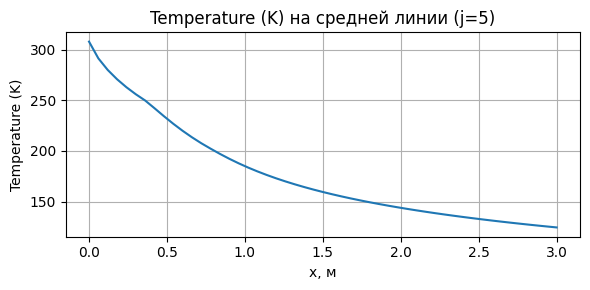

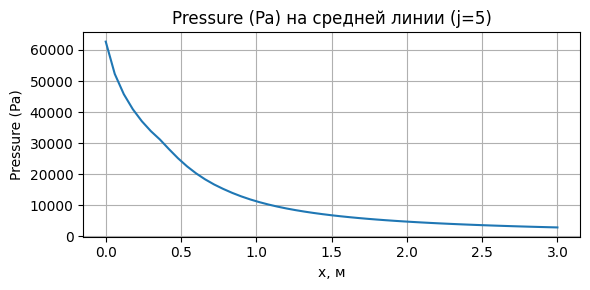

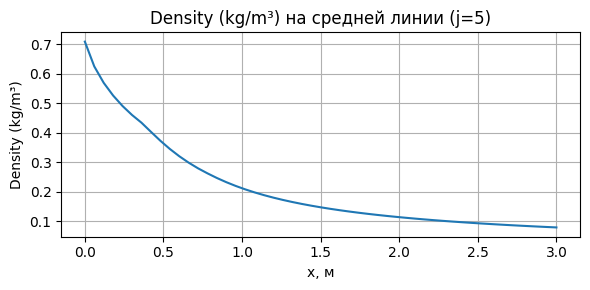

In [ ]:
fields = {
    "Speed (m/s)": (w, "w"),
    "Mach number": (M, "M"),
    "Temperature (K)": (T, "T"),
    "Pressure (Pa)": (p, "p"),
    "Density (kg/m³)": (rho, "rho"),
    "Speed (m/s)": (w, "w")
}

j_mid = Ny // 2

for title, (field, var) in fields.items():
    mid_dist = field[:, j_mid]
    plt.figure(figsize=(6,3))
    plt.plot(x, mid_dist)
    plt.xlabel('x, м')
    plt.ylabel(title)
    plt.title(f'{title} на средней линии (j={j_mid})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
x, yg1, fields = run_schm(
        gamma=1.4, R=287, p_ref=62691.4, rho_ref=0.7097, M_ref=1.372,
        L=3.0, h0=1.0, h1=4.0, Nx=50, Ny=10
    )
x_samples = [0, 1.5, 2.0, 3.0]
j0 = 0

# Печать сравнения в табличном виде
print(f"{'x':>5} | {'w_num':>8} {'w_an':>8} | {'M_num':>6} {'M_an':>6} | {'p_num':>9} {'p_an':>9} | {'rho_num':>8} {'rho_an':>8}")
print("-"*85)
for xs in x_samples:
    i = np.argmin(np.abs(x - xs))
    w_num = fields['w'][i, j0+3]
    M_num = fields['M'][i, j0+3]
    p_num = fields['p'][i, j0+2]
    rho_num = fields['rho'][i, j0+2]

    r_val = xs + 1.1
    w_an, M_an, p_an, rho_an = analytical_point_source(r_val)
    #print(f"{xs:5.1f} | {w_num:8.2f} {w_an:8.2f} | {M_num:6.3f} {M_an:6.3f} | {p_num:9.1f} {p_an:9.1f} | {rho_num:8.4f} {rho_an:8.4f}")
    err_w   = (w_num   - w_an)   / w_an   * 100
    err_M   = (M_num   - M_an)   / M_an   * 100
    err_p   = (p_num   - p_an)   / p_an   * 100
    err_rho = (rho_num - rho_an) / rho_an * 100


    print(f"{xs:5.1f} | "
          f"{w_num:8.3f} {w_an:8.3f} {err_w:6.2f} | "
          f"{M_num:6.3f} {M_an:6.3f} {err_M:6.2f} | "
          f"{p_num:9.1f} {p_an:9.1f} {err_p:6.2f} | "
          f"{rho_num:8.4f} {rho_an:8.4f} {err_rho:6.2f}")


    x |    w_num     w_an |  M_num   M_an |     p_num      p_an |  rho_num   rho_an
-------------------------------------------------------------------------------------
  0.0 |  482.486  482.463   0.00 |  1.372  1.372   0.01 |   62691.4   62691.4  -0.00 |   0.7097   0.7097   0.00
  1.5 |  692.151  685.793   0.93 |  2.541  2.485   2.26 |   12684.5   11491.4  10.38 |   0.2294   0.2112   8.60
  2.0 |  716.295  707.521   1.24 |  2.760  2.672   3.28 |    9330.1    8599.4   8.50 |   0.1844   0.1717   7.40
  3.0 |  748.159  736.681   1.56 |  3.108  2.966   4.78 |    5650.1    5494.4   2.83 |   0.1291   0.1247   3.51


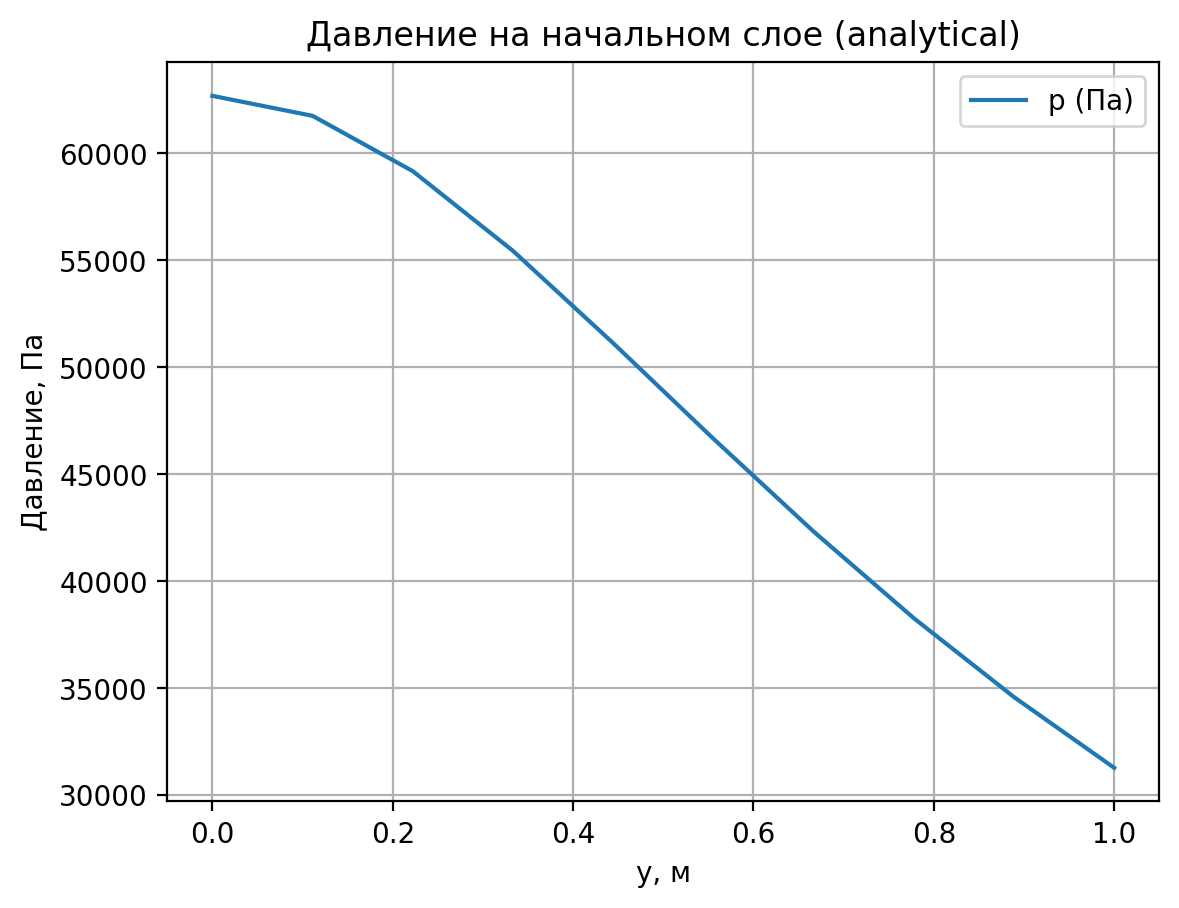

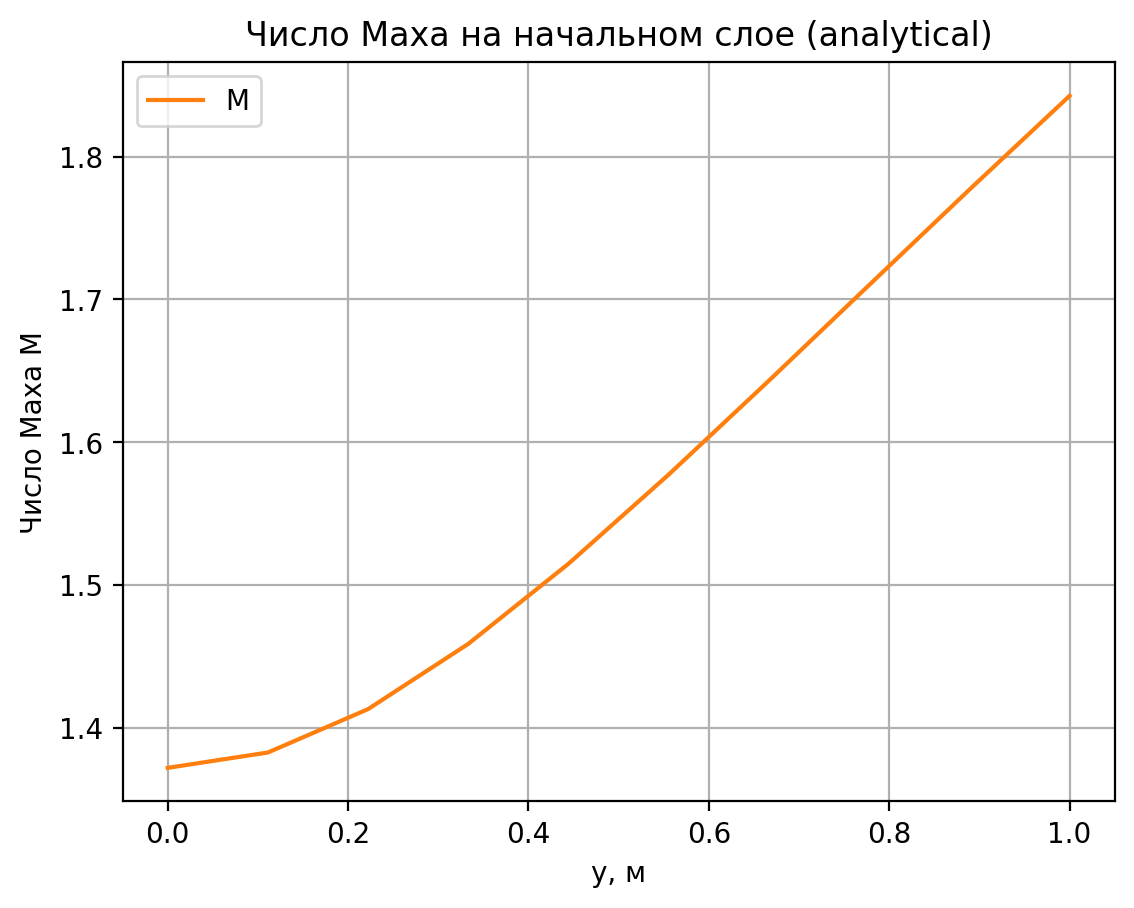

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

gamma, R = 1.4, 287.0
p_ref, rho_ref, M_ref = 62691.4, 0.7097, 1.372
L, h0, h1 = 3.0, 1.0, 4.0
Nx, Ny = 50, 10

x = np.linspace(0, L, Nx+1)
y0 = np.linspace(0, h0, Ny)

u   = np.zeros((Nx+1, Ny))
v   = np.zeros((Nx+1, Ny))
p   = np.zeros((Nx+1, Ny))
rho = np.zeros((Nx+1, Ny))
M   = np.zeros((Nx+1, Ny))


for j in range(Ny):
    xi, yi = x[0], y0[j]
    r = math.hypot(xi+1.1, yi)
    w_j, M_j, p_j, rho_j = analytical_point_source(r)
    theta = math.atan2(yi, xi + 1e-8)
    u[0,j]   = w_j * math.cos(theta)
    v[0,j]   = w_j * math.sin(theta)
    p[0,j]   = p_j
    rho[0,j] = rho_j
    M[0,j]   = M_j


plt.figure()
plt.plot(y0, p[0,:], label='p (Па)')
plt.title("Давление на начальном слое (analytical)")
plt.xlabel("y, м")
plt.ylabel("Давление, Па")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(y0, M[0,:], color='C1', label='M')
plt.title("Число Маха на начальном слое (analytical)")
plt.xlabel("y, м")
plt.ylabel("Число Маха M")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d


gamma, R = 1.4, 287.0
p_ref, rho_ref, M_ref = 62691.4, 0.7097, 1.372
L, h0, h1 = 3.0, 1.0, 4.0
Nx, Ny = 50, 10
eps = 1e-8

x = np.linspace(0, L, Nx+1)
y = np.linspace(0, h0, Ny)


u = np.zeros((Nx+1, Ny))
v = np.zeros((Nx+1, Ny))
p = np.zeros((Nx+1, Ny))
rho = np.zeros((Nx+1, Ny))


for j in range(Ny):
    xi, yi = x[0] + 1.1, y[j]
    r = math.hypot(xi, yi)
    w_j, M_j, p_j, rho_j = analytical_point_source(r)
    theta = math.atan2(yi, xi)
    u[0,j]   = w_j * math.cos(theta)
    v[0,j]   = w_j * math.sin(theta)
    p[0,j]   = p_j
    rho[0,j] = rho_j


def top_wall(x): return h0 + (h1-h0)*(x/L)
def sound_speed(p_,r_): return np.sqrt(gamma*np.maximum(p_,eps)/np.maximum(r_,eps))
def enthalpy(p_,r_): return gamma/(gamma-1)*p_/np.maximum(r_,eps)
def interp_y_quadratic(f, yg, yv, eps=1e-8):

    i = np.searchsorted(yg, yv)
    N = len(yg)

    if i < 1:
        idxs = [0, 1, 2]
    elif i > N-2:
        idxs = [N-3, N-2, N-1]
    else:
        idxs = [i-1, i, i+1]

    x0, x1, x2 = yg[idxs]
    f0, f1, f2 = f[idxs]


    L0 = ((yv - x1)*(yv - x2)) / ((x0 - x1)*(x0 - x2) + eps)
    L1 = ((yv - x0)*(yv - x2)) / ((x1 - x0)*(x1 - x2) + eps)
    L2 = ((yv - x0)*(yv - x1)) / ((x2 - x0)*(x2 - x1) + eps)

    return L0*f0 + L1*f1 + L2*f2
def interp_y(field, yg, y_val):


    interpolator = interp1d(yg, field, kind='quadratic',
                            fill_value="extrapolate", assume_sorted=True)

    return float(interpolator(y_val))
'''def interp_y(f, yg, yv):
    j = np.clip(np.searchsorted(yg,yv)-1,0,len(yg)-2)
    yj,yj1 = yg[j], yg[j+1]
    w1=(yj1-yv)/(yj1-yj+eps)
    w2=(yv-yj)/(yj1-yj+eps)
    return w1*f[j]+w2*f[j+1]'''

def compute_F(U, uk,vk,pk,rk,yg,dx,y3):
    u3,v3,p3,r3 = U
    p3,r3 = np.clip(p3,eps,None),np.clip(r3,eps,None)
    theta = np.arctan2(v3,u3)
    w3=np.hypot(u3,v3)+eps
    a3=sound_speed(p3,r3)
    mu=np.arcsin(np.clip(a3/w3,-1,1))
    lamp,lamm,lam0 = np.tan(theta+mu),np.tan(theta-mu),v3/(u3+eps)
    y1,y2,y4 = y3-lamp*dx, y3-lamm*dx, y3-lam0*dx
    u1,v1 = interp_y(uk,yg,y1), interp_y(vk,yg,y1)
    p1,r1 = interp_y(pk,yg,y1), interp_y(rk,yg,y1)
    u2,v2 = interp_y(uk,yg,y2), interp_y(vk,yg,y2)
    p2,r2 = interp_y(pk,yg,y2), interp_y(rk,yg,y2)
    u4,v4 = interp_y(uk,yg,y4), interp_y(vk,yg,y4)
    p4,r4 = interp_y(pk,yg,y4), interp_y(rk,yg,y4)
    p4,r4 = np.clip(p4,eps,None),np.clip(r4,eps,None)
    a1,a2,a4 = sound_speed(p1,r1),sound_speed(p2,r2),sound_speed(p4,r4)
    w1,w2,w4 = np.hypot(u1,v1)+eps, np.hypot(u2,v2)+eps, np.hypot(u4,v4)+eps
    mu1,mu2 = np.arcsin(np.clip(a1/w1,-1,1)),np.arcsin(np.clip(a2/w2,-1,1))
    cot1,cot2 = np.cos(mu1)/(np.sin(mu1)+eps),np.cos(mu2)/(np.sin(mu2)+eps)
    F1 = theta-np.arctan2(v1,u1)+cot1*(p3-p1)/(r1*w1*w1+eps)
    F2 = theta-np.arctan2(v2,u2)-cot2*(p3-p2)/(r2*w2*w2+eps)
    F3 = p3-p4 - a4*a4*(r3-r4)
    dh = np.clip(enthalpy(p3,r3)-enthalpy(p4,r4),-1e6,1e6)
    dv = np.clip(0.5*((u3**2+v3**2)-(u4**2+v4**2)),-1e6,1e6)
    F4 = dh+dv
    return np.array([F1,F2,F3,F4])

for k in range(Nx):
    dx = x[k+1]-x[k]
    yg = np.linspace(0,top_wall(x[k]),Ny)
    for j in range(Ny):
        U = np.array([u[k,j],v[k,j],p[k,j],rho[k,j]])
        uk,vk,pk,rk = u[k,:],v[k,:],p[k,:],rho[k,:]
        y3 = yg[j]
        for _ in range(30):
            F = compute_F(U,uk,vk,pk,rk,yg,dx,y3)
            if not np.all(np.isfinite(F)): break
            J = np.zeros((4,4))
            for i in range(4):
                dU = np.zeros(4); dU[i]=1e-8
                J[:,i] = (compute_F(U+dU,uk,vk,pk,rk,yg,dx,y3)-F)/1e-8
            try: dU=np.linalg.solve(J,-F)
            except: dU=-np.linalg.pinv(J).dot(F)
            U_new = U+dU
            U_new[2:]=np.clip(U_new[2:],eps,None)
            w_new,a_new = np.hypot(U_new[0],U_new[1]),sound_speed(U_new[2],U_new[3])
            if w_new/(a_new+eps)>5:
                scale=5*a_new/(w_new+eps)
                U_new[0]*=scale
                U_new[1]*=scale
            if np.linalg.norm(dU,np.inf)<1e-8:
              U=U_new
              break
            U=U_new
        u[k+1,j],v[k+1,j],p[k+1,j],rho[k+1,j]=U

w = np.hypot(u,v)
M = w/np.sqrt(gamma*p/rho)

data = {}

i1 = np.argmin(np.abs(x-2.0))
w_num,M_num,p_num,rho_num = w[i1,:], M[i1,:], p[i1,:], rho[i1,:]
w_an,M_an,p_an,rho_an = [],[],[],[]
for j in range(Ny):
    r = math.hypot(x[i1]+1.1, y[j])
    wa,Ma,pa,ra = analytical_point_source(r)
    w_an.append(wa); M_an.append(Ma); p_an.append(pa); rho_an.append(ra)
w_an,M_an,p_an,rho_an = map(np.array,(w_an,M_an,p_an,rho_an))
err_w = 100*(w_num - w_an)/w_an
err_M = 100*(M_num - M_an)/M_an
data[Ny] = (y, w_num, M_num, w_an, M_an, err_w, err_M)


'''plt.figure(figsize=(10,6))
labels = ['w','M','p','rho']
num = [w_num,M_num,p_num,rho_num]
ana = [w_an,M_an,p_an,rho_an]
titles = ['Speed','Mach','Pressure','Density']
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(y, num[i], label='СХМ')
    plt.plot(y, ana[i], label='Analytic')
    plt.title(titles[i]); plt.xlabel('y, m'); plt.legend(); plt.grid()
plt.tight_layout()
plt.show()'''


"plt.figure(figsize=(10,6))\nlabels = ['w','M','p','rho']\nnum = [w_num,M_num,p_num,rho_num]\nana = [w_an,M_an,p_an,rho_an]\ntitles = ['Speed','Mach','Pressure','Density']\nfor i in range(4):\n    plt.subplot(2,2,i+1)\n    plt.plot(y, num[i], label='СХМ')\n    plt.plot(y, ana[i], label='Analytic')\n    plt.title(titles[i]); plt.xlabel('y, m'); plt.legend(); plt.grid()\nplt.tight_layout()\nplt.show()"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d



gamma, R = 1.4, 287.0
p_ref, rho_ref, M_ref = 62691.4, 0.7097, 1.372
L, h0, h1 = 3.0, 1.0, 4.0
Nx, Ny = 50, 50
eps = 1e-8

x = np.linspace(0, L, Nx+1)
y = np.linspace(0, h0, Ny)

u = np.zeros((Nx+1, Ny))
v = np.zeros((Nx+1, Ny))
p = np.zeros((Nx+1, Ny))
rho = np.zeros((Nx+1, Ny))


for j in range(Ny):
    xi, yi = x[0] + 1.1, y[j]
    r = math.hypot(xi, yi)
    w_j, M_j, p_j, rho_j = analytical_point_source(r)
    theta = math.atan2(yi, xi)
    u[0,j]   = w_j * math.cos(theta)
    v[0,j]   = w_j * math.sin(theta)
    p[0,j]   = p_j
    rho[0,j] = rho_j


def top_wall(x): return h0 + (h1-h0)*(x/L)
def sound_speed(p_,r_): return np.sqrt(gamma*np.maximum(p_,eps)/np.maximum(r_,eps))
def enthalpy(p_,r_): return gamma/(gamma-1)*p_/np.maximum(r_,eps)
def interp_y_quadratic(f, yg, yv, eps=1e-8):

    i = np.searchsorted(yg, yv)
    N = len(yg)

    if i < 1:
        idxs = [0, 1, 2]
    elif i > N-2:
        idxs = [N-3, N-2, N-1]
    else:
        idxs = [i-1, i, i+1]

    x0, x1, x2 = yg[idxs]
    f0, f1, f2 = f[idxs]


    L0 = ((yv - x1)*(yv - x2)) / ((x0 - x1)*(x0 - x2) + eps)
    L1 = ((yv - x0)*(yv - x2)) / ((x1 - x0)*(x1 - x2) + eps)
    L2 = ((yv - x0)*(yv - x1)) / ((x2 - x0)*(x2 - x1) + eps)

    return L0*f0 + L1*f1 + L2*f2
def interp_y(field, yg, y_val):


    interpolator = interp1d(yg, field, kind='quadratic',
                            fill_value="extrapolate", assume_sorted=True)

    return float(interpolator(y_val))
'''def interp_y(f, yg, yv):
    j = np.clip(np.searchsorted(yg,yv)-1,0,len(yg)-2)
    yj,yj1 = yg[j], yg[j+1]
    w1=(yj1-yv)/(yj1-yj+eps)
    w2=(yv-yj)/(yj1-yj+eps)
    return w1*f[j]+w2*f[j+1]'''

def compute_F(U, uk,vk,pk,rk,yg,dx,y3):
    u3,v3,p3,r3 = U
    p3,r3 = np.clip(p3,eps,None),np.clip(r3,eps,None)
    theta = np.arctan2(v3,u3)
    w3=np.hypot(u3,v3)+eps
    a3=sound_speed(p3,r3)
    mu=np.arcsin(np.clip(a3/w3,-1,1))
    lamp,lamm,lam0 = np.tan(theta+mu),np.tan(theta-mu),v3/(u3+eps)
    y1,y2,y4 = y3-lamp*dx, y3-lamm*dx, y3-lam0*dx
    u1,v1 = interp_y(uk,yg,y1), interp_y(vk,yg,y1)
    p1,r1 = interp_y(pk,yg,y1), interp_y(rk,yg,y1)
    u2,v2 = interp_y(uk,yg,y2), interp_y(vk,yg,y2)
    p2,r2 = interp_y(pk,yg,y2), interp_y(rk,yg,y2)
    u4,v4 = interp_y(uk,yg,y4), interp_y(vk,yg,y4)
    p4,r4 = interp_y(pk,yg,y4), interp_y(rk,yg,y4)
    p4,r4 = np.clip(p4,eps,None),np.clip(r4,eps,None)
    a1,a2,a4 = sound_speed(p1,r1),sound_speed(p2,r2),sound_speed(p4,r4)
    w1,w2,w4 = np.hypot(u1,v1)+eps, np.hypot(u2,v2)+eps, np.hypot(u4,v4)+eps
    mu1,mu2 = np.arcsin(np.clip(a1/w1,-1,1)),np.arcsin(np.clip(a2/w2,-1,1))
    cot1,cot2 = np.cos(mu1)/(np.sin(mu1)+eps),np.cos(mu2)/(np.sin(mu2)+eps)
    F1 = theta-np.arctan2(v1,u1)+cot1*(p3-p1)/(r1*w1*w1+eps)
    F2 = theta-np.arctan2(v2,u2)-cot2*(p3-p2)/(r2*w2*w2+eps)
    F3 = p3-p4 - a4*a4*(r3-r4)
    dh = np.clip(enthalpy(p3,r3)-enthalpy(p4,r4),-1e6,1e6)
    dv = np.clip(0.5*((u3**2+v3**2)-(u4**2+v4**2)),-1e6,1e6)
    F4 = dh+dv
    return np.array([F1,F2,F3,F4])


for k in range(Nx):
    dx = x[k+1]-x[k]
    yg = np.linspace(0,top_wall(x[k]),Ny)
    for j in range(Ny):
        U = np.array([u[k,j],v[k,j],p[k,j],rho[k,j]])
        uk,vk,pk,rk = u[k,:],v[k,:],p[k,:],rho[k,:]
        y3 = yg[j]
        for _ in range(30):
            F = compute_F(U,uk,vk,pk,rk,yg,dx,y3)
            if not np.all(np.isfinite(F)): break
            J = np.zeros((4,4))
            for i in range(4):
                dU = np.zeros(4); dU[i]=1e-8
                J[:,i] = (compute_F(U+dU,uk,vk,pk,rk,yg,dx,y3)-F)/1e-8
            try: dU=np.linalg.solve(J,-F)
            except: dU=-np.linalg.pinv(J).dot(F)
            U_new = U+dU
            U_new[2:]=np.clip(U_new[2:],eps,None)
            w_new,a_new = np.hypot(U_new[0],U_new[1]),sound_speed(U_new[2],U_new[3])
            if w_new/(a_new+eps)>5:
                scale=5*a_new/(w_new+eps)
                U_new[0]*=scale
                U_new[1]*=scale
            if np.linalg.norm(dU,np.inf)<1e-8:
              U=U_new
              break
            U=U_new
        u[k+1,j],v[k+1,j],p[k+1,j],rho[k+1,j]=U


w = np.hypot(u,v)
M = w/np.sqrt(gamma*p/rho)



i1 = np.argmin(np.abs(x-2.0))
w_num,M_num,p_num,rho_num = w[i1,:], M[i1,:], p[i1,:], rho[i1,:]
w_an,M_an,p_an,rho_an = [],[],[],[]
for j in range(Ny):
    r = math.hypot(x[i1]+1.1, y[j])
    wa,Ma,pa,ra = analytical_point_source(r)
    w_an.append(wa)
    M_an.append(Ma)
    p_an.append(pa)
    rho_an.append(ra)
w_an,M_an,p_an,rho_an = map(np.array,(w_an,M_an,p_an,rho_an))
err_w = 100*(w_num - w_an)/w_an
err_M = 100*(M_num - M_an)/M_an
data[Ny] = (y, w_num, M_num, w_an, M_an, err_w, err_M)

'''plt.figure(figsize=(10,6))
labels = ['w','M','p','rho']
num = [w_num,M_num,p_num,rho_num]
ana = [w_an,M_an,p_an,rho_an]
titles = ['Speed','Mach','Pressure','Density']
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(y, num[i], label='СХМ')
    plt.plot(y, ana[i], label='Analytic')
    plt.title(titles[i]); plt.xlabel('y, m'); plt.legend(); plt.grid()
plt.tight_layout()
plt.show()'''


"plt.figure(figsize=(10,6))\nlabels = ['w','M','p','rho']\nnum = [w_num,M_num,p_num,rho_num]\nana = [w_an,M_an,p_an,rho_an]\ntitles = ['Speed','Mach','Pressure','Density']\nfor i in range(4):\n    plt.subplot(2,2,i+1)\n    plt.plot(y, num[i], label='СХМ')\n    plt.plot(y, ana[i], label='Analytic')\n    plt.title(titles[i]); plt.xlabel('y, m'); plt.legend(); plt.grid()\nplt.tight_layout()\nplt.show()"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d



gamma, R = 1.4, 287.0
p_ref, rho_ref, M_ref = 62691.4, 0.7097, 1.372
L, h0, h1 = 3.0, 1.0, 4.0
Nx, Ny = 50, 100
eps = 1e-8

x = np.linspace(0, L, Nx+1)
y = np.linspace(0, h0, Ny)


u = np.zeros((Nx+1, Ny))
v = np.zeros((Nx+1, Ny))
p = np.zeros((Nx+1, Ny))
rho = np.zeros((Nx+1, Ny))


for j in range(Ny):
    xi, yi = x[0] + 1.1, y[j]
    r = math.hypot(xi, yi)
    w_j, M_j, p_j, rho_j = analytical_point_source(r)
    theta = math.atan2(yi, xi)
    u[0,j]   = w_j * math.cos(theta)
    v[0,j]   = w_j * math.sin(theta)
    p[0,j]   = p_j
    rho[0,j] = rho_j


def top_wall(x): return h0 + (h1-h0)*(x/L)
def sound_speed(p_,r_): return np.sqrt(gamma*np.maximum(p_,eps)/np.maximum(r_,eps))
def enthalpy(p_,r_): return gamma/(gamma-1)*p_/np.maximum(r_,eps)
def interp_y_quadratic(f, yg, yv, eps=1e-8):

    i = np.searchsorted(yg, yv)
    N = len(yg)

    if i < 1:
        idxs = [0, 1, 2]
    elif i > N-2:
        idxs = [N-3, N-2, N-1]
    else:
        idxs = [i-1, i, i+1]

    x0, x1, x2 = yg[idxs]
    f0, f1, f2 = f[idxs]


    L0 = ((yv - x1)*(yv - x2)) / ((x0 - x1)*(x0 - x2) + eps)
    L1 = ((yv - x0)*(yv - x2)) / ((x1 - x0)*(x1 - x2) + eps)
    L2 = ((yv - x0)*(yv - x1)) / ((x2 - x0)*(x2 - x1) + eps)

    return L0*f0 + L1*f1 + L2*f2
def interp_y(field, yg, y_val):

    interpolator = interp1d(yg, field, kind='quadratic',
                            fill_value="extrapolate", assume_sorted=True)

    return float(interpolator(y_val))
'''def interp_y(f, yg, yv):
    j = np.clip(np.searchsorted(yg,yv)-1,0,len(yg)-2)
    yj,yj1 = yg[j], yg[j+1]
    w1=(yj1-yv)/(yj1-yj+eps)
    w2=(yv-yj)/(yj1-yj+eps)
    return w1*f[j]+w2*f[j+1]'''

def compute_F(U, uk,vk,pk,rk,yg,dx,y3):
    u3,v3,p3,r3 = U
    p3,r3 = np.clip(p3,eps,None),np.clip(r3,eps,None)
    theta = np.arctan2(v3,u3)
    w3=np.hypot(u3,v3)+eps
    a3=sound_speed(p3,r3)
    mu=np.arcsin(np.clip(a3/w3,-1,1))
    lamp,lamm,lam0 = np.tan(theta+mu),np.tan(theta-mu),v3/(u3+eps)
    y1,y2,y4 = y3-lamp*dx, y3-lamm*dx, y3-lam0*dx
    u1,v1 = interp_y(uk,yg,y1), interp_y(vk,yg,y1)
    p1,r1 = interp_y(pk,yg,y1), interp_y(rk,yg,y1)
    u2,v2 = interp_y(uk,yg,y2), interp_y(vk,yg,y2)
    p2,r2 = interp_y(pk,yg,y2), interp_y(rk,yg,y2)
    u4,v4 = interp_y(uk,yg,y4), interp_y(vk,yg,y4)
    p4,r4 = interp_y(pk,yg,y4), interp_y(rk,yg,y4)
    p4,r4 = np.clip(p4,eps,None),np.clip(r4,eps,None)
    a1,a2,a4 = sound_speed(p1,r1),sound_speed(p2,r2),sound_speed(p4,r4)
    w1,w2,w4 = np.hypot(u1,v1)+eps, np.hypot(u2,v2)+eps, np.hypot(u4,v4)+eps
    mu1,mu2 = np.arcsin(np.clip(a1/w1,-1,1)),np.arcsin(np.clip(a2/w2,-1,1))
    cot1,cot2 = np.cos(mu1)/(np.sin(mu1)+eps),np.cos(mu2)/(np.sin(mu2)+eps)
    F1 = theta-np.arctan2(v1,u1)+cot1*(p3-p1)/(r1*w1*w1+eps)
    F2 = theta-np.arctan2(v2,u2)-cot2*(p3-p2)/(r2*w2*w2+eps)
    F3 = p3-p4 - a4*a4*(r3-r4)
    dh = np.clip(enthalpy(p3,r3)-enthalpy(p4,r4),-1e6,1e6)
    dv = np.clip(0.5*((u3**2+v3**2)-(u4**2+v4**2)),-1e6,1e6)
    F4 = dh+dv
    return np.array([F1,F2,F3,F4])


for k in range(Nx):
    dx = x[k+1]-x[k]
    yg = np.linspace(0,top_wall(x[k]),Ny)
    for j in range(Ny):
        U = np.array([u[k,j],v[k,j],p[k,j],rho[k,j]])
        uk,vk,pk,rk = u[k,:],v[k,:],p[k,:],rho[k,:]
        y3 = yg[j]
        for _ in range(30):
            F = compute_F(U,uk,vk,pk,rk,yg,dx,y3)
            if not np.all(np.isfinite(F)): break
            J = np.zeros((4,4))
            for i in range(4):
                dU = np.zeros(4); dU[i]=1e-8
                J[:,i] = (compute_F(U+dU,uk,vk,pk,rk,yg,dx,y3)-F)/1e-8
            try: dU=np.linalg.solve(J,-F)
            except: dU=-np.linalg.pinv(J).dot(F)
            U_new = U+dU
            U_new[2:]=np.clip(U_new[2:],eps,None)
            w_new,a_new = np.hypot(U_new[0],U_new[1]),sound_speed(U_new[2],U_new[3])
            if w_new/(a_new+eps)>5:
                scale=5*a_new/(w_new+eps)
                U_new[0]*=scale
                U_new[1]*=scale
            if np.linalg.norm(dU,np.inf)<1e-8:
              U=U_new
              break
            U=U_new
        u[k+1,j],v[k+1,j],p[k+1,j],rho[k+1,j]=U


w = np.hypot(u,v)
M = w/np.sqrt(gamma*p/rho)



i1 = np.argmin(np.abs(x-2.0))
w_num,M_num,p_num,rho_num = w[i1,:], M[i1,:], p[i1,:], rho[i1,:]
w_an,M_an,p_an,rho_an = [],[],[],[]
for j in range(Ny):
    r = math.hypot(x[i1]+1.1, y[j])
    wa,Ma,pa,ra = analytical_point_source(r)
    w_an.append(wa)
    M_an.append(Ma)
    p_an.append(pa)
    rho_an.append(ra)
w_an,M_an,p_an,rho_an = map(np.array,(w_an,M_an,p_an,rho_an))
err_w = 100*(w_num - w_an)/w_an
err_M = 100*(M_num - M_an)/M_an
data[Ny] = (y, w_num, M_num, w_an, M_an, err_w, err_M)

# -- Plot profiles --
'''plt.figure(figsize=(10,6))
labels = ['w','M','p','rho']
num = [w_num,M_num,p_num,rho_num]
ana = [w_an,M_an,p_an,rho_an]
titles = ['Speed','Mach','Pressure','Density']
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(y, num[i], label='СХМ')
    plt.plot(y, ana[i], label='Analytic')
    plt.title(titles[i]); plt.xlabel('y, m'); plt.legend(); plt.grid()
plt.tight_layout()
plt.show()'''


"plt.figure(figsize=(10,6))\nlabels = ['w','M','p','rho']\nnum = [w_num,M_num,p_num,rho_num]\nana = [w_an,M_an,p_an,rho_an]\ntitles = ['Speed','Mach','Pressure','Density']\nfor i in range(4):\n    plt.subplot(2,2,i+1)\n    plt.plot(y, num[i], label='СХМ')\n    plt.plot(y, ana[i], label='Analytic')\n    plt.title(titles[i]); plt.xlabel('y, m'); plt.legend(); plt.grid()\nplt.tight_layout()\nplt.show()"

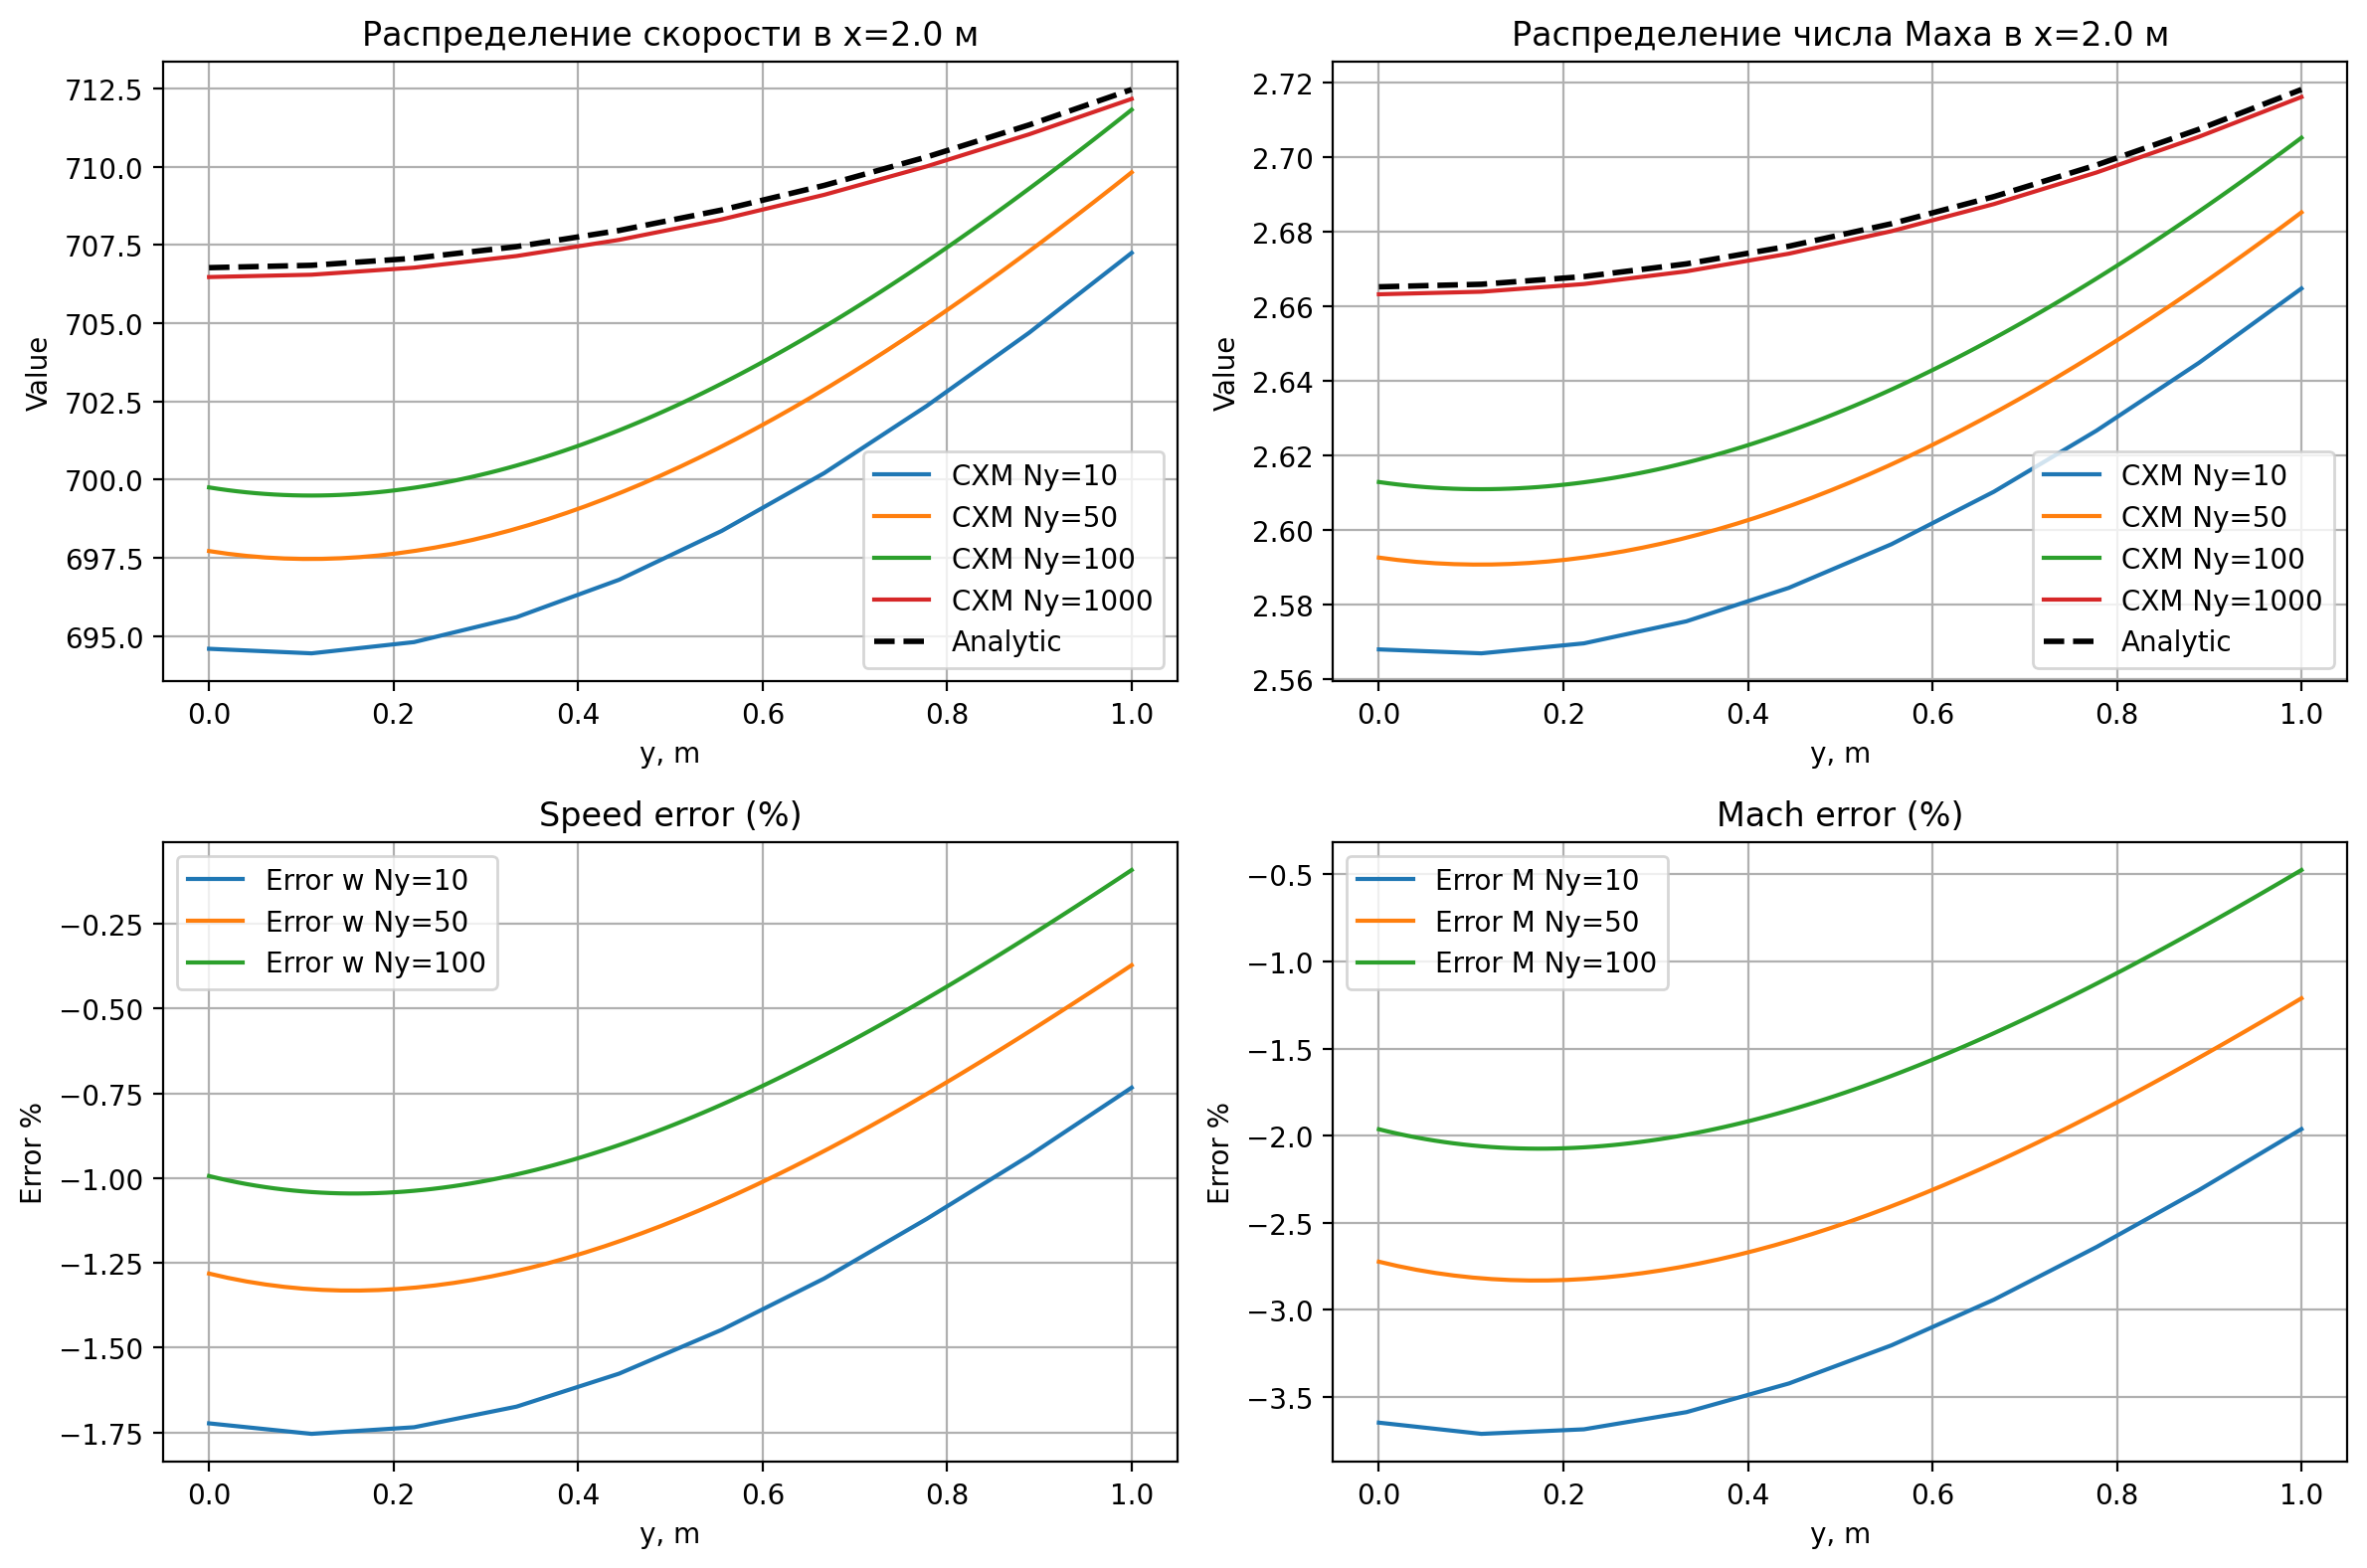

In [ ]:
Ny_list = [10,50,100,1000]


fig, axes = plt.subplots(2,2, figsize=(12,8))
(ax_w, ax_M), (ax_ew, ax_eM) = axes


for Ny in Ny_list:
    y, w_num, M_num, w_an, M_an, _, _ = data[Ny]
    ax_w.plot(y, w_num, label=f'СХМ Ny={Ny}')
    ax_M.plot(y, M_num, label=f'СХМ Ny={Ny}')

y0 = data[Ny_list[0]][0]


ax_w.plot(y0, data[Ny_list[0]][3], 'k--', lw=2, label='Analytic')
ax_M.plot(y0, data[Ny_list[0]][4], 'k--', lw=2, label='Analytic')



ax_w.set_title('Распределение скорости в x=2.0 м')
ax_M.set_title('Распределение числа Маха в x=2.0 м')
for ax in (ax_w, ax_M):
    ax.set_xlabel('y, m')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.legend()


for Ny in Ny_list:
    y, _, _, _, _, err_w, err_M = data[Ny]
    ax_ew.plot(y, err_w, label=f'Error w Ny={Ny}')
    ax_eM.plot(y, err_M, label=f'Error M Ny={Ny}')

ax_ew.set_title('Speed error (%)')
ax_eM.set_title('Mach error (%)')
for ax in (ax_ew, ax_eM):
    ax.set_xlabel('y, m')
    ax.set_ylabel('Error %')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

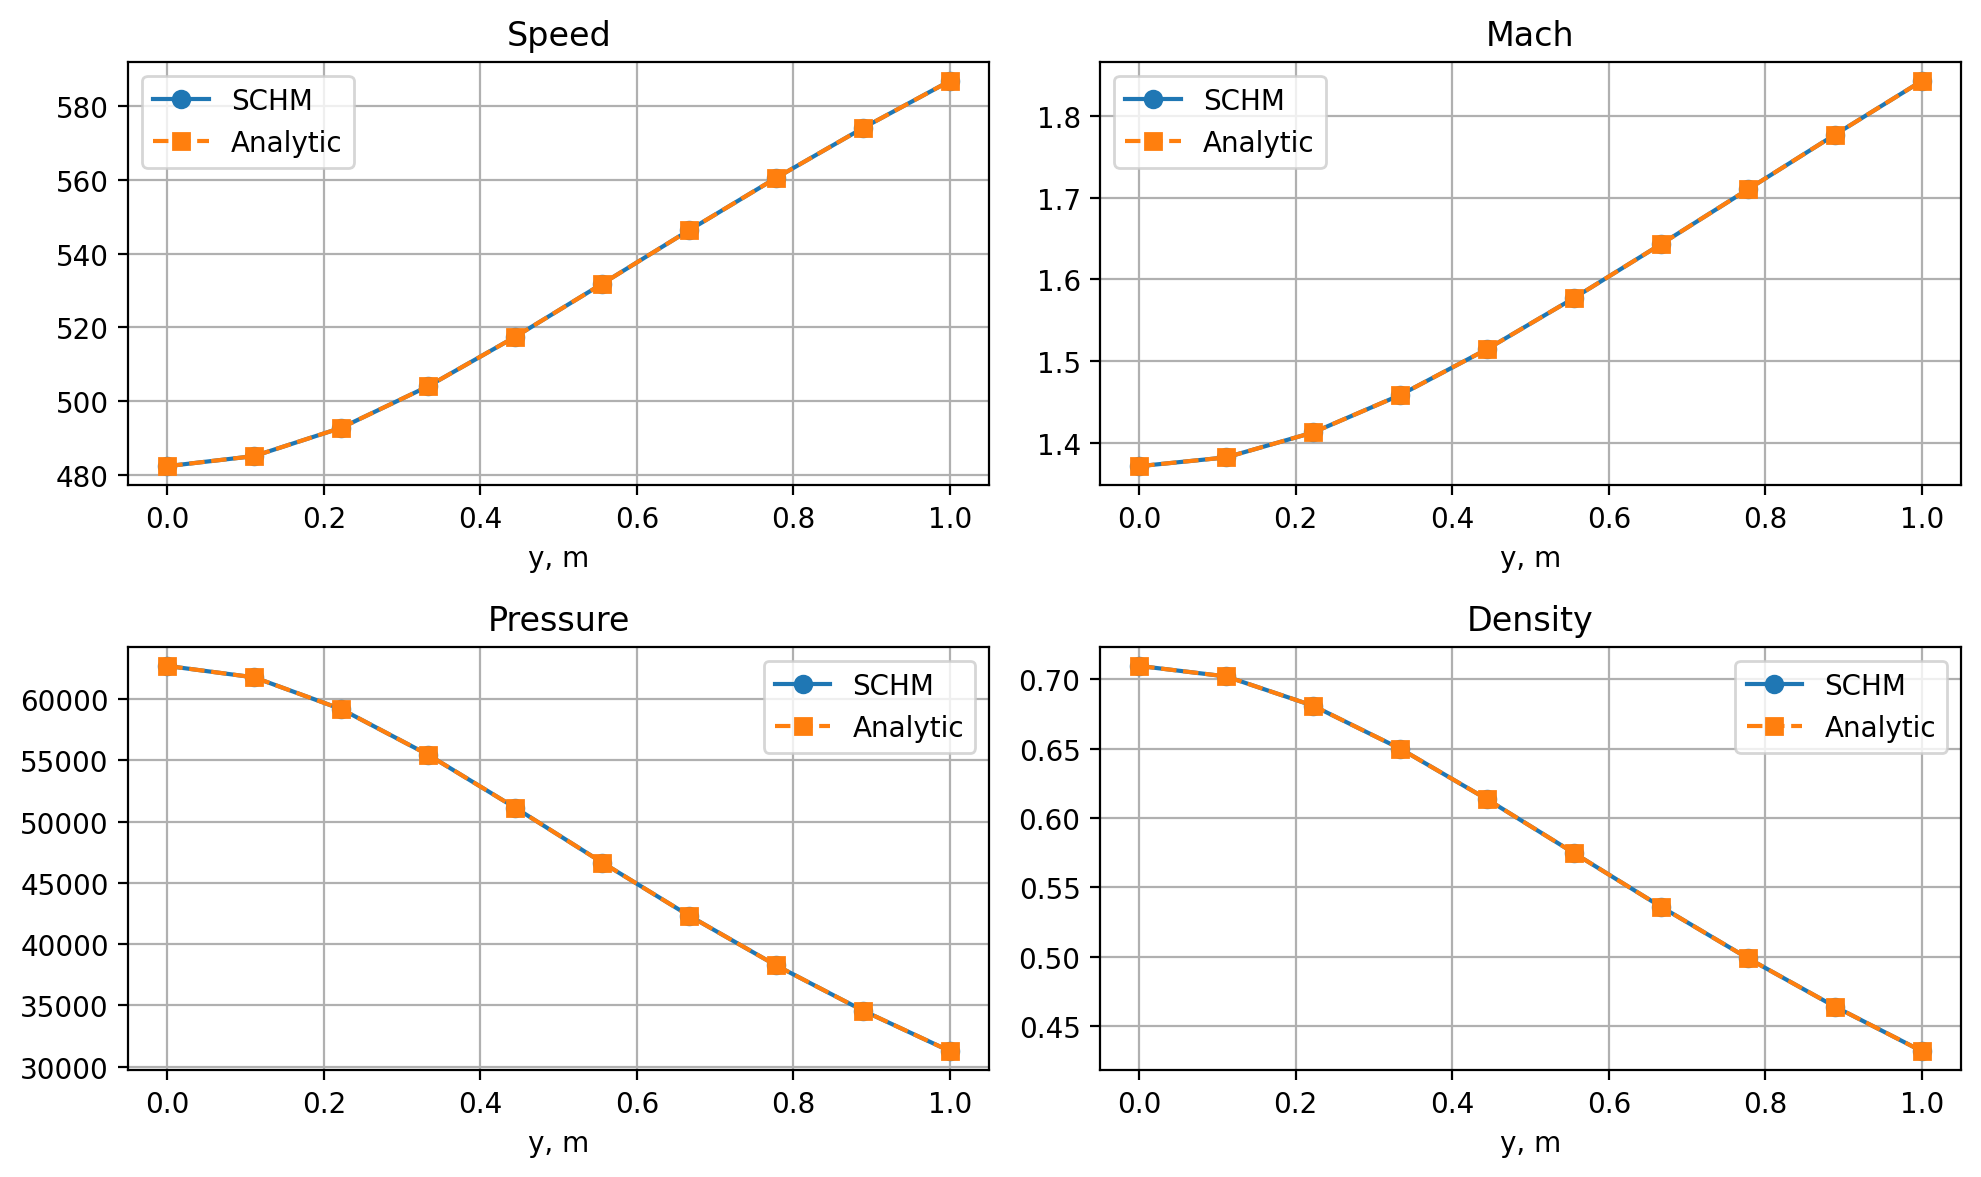

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math


def run_schm(gamma, R, p_ref, rho_ref, M_ref, L, h0, h1, Nx, Ny,
             max_iter=10, tol=1e-6, delta=1e-6, M_max=5.0, eps=1e-8):
    def top_wall(x): return h0 + (h1-h0)*(x/L)
    def sound_speed(p_,r_): return np.sqrt(gamma*max(p_,eps)/max(r_,eps))
    def enthalpy(p_,r_): return gamma/(gamma-1)*p_/max(r_,eps)
    def interp_y(f,yg,yv):
        j= min(max(np.searchsorted(yg,yv)-1,0),len(yg)-2)
        yj,yj1=yg[j],yg[j+1]
        w1=(yj1-yv)/(yj1-yj+eps); w2=(yv-yj)/(yj1-yj+eps)
        return w1*f[j]+w2*f[j+1]
    def compute_F(U,uk,vk,pk,rk,yg,dx,y3):
        u3,v3,p3,r3=U
        p3,r3=max(p3,eps),max(r3,eps)
        theta=np.arctan2(v3,u3); w3=np.hypot(u3,v3)+eps
        a3=sound_speed(p3,r3); mu=np.arcsin(np.clip(a3/w3,-1,1))
        lamp,lamm,lam0=np.tan(theta+mu),np.tan(theta-mu),v3/(u3+eps)
        y1,y2,y4=y3-lamp*dx,y3-lamm*dx,y3-lam0*dx
        u1,v1=interp_y(uk,yg,y1),interp_y(vk,yg,y1)
        p1,r1=interp_y(pk,yg,y1),interp_y(rk,yg,y1)
        u2,v2=interp_y(uk,yg,y2),interp_y(vk,yg,y2)
        p2,r2=interp_y(pk,yg,y2),interp_y(rk,yg,y2)
        u4,v4=interp_y(uk,yg,y4),interp_y(vk,yg,y4)
        p4,r4=interp_y(pk,yg,y4),interp_y(rk,yg,y4)
        p4,r4=max(p4,eps),max(r4,eps)
        a1,a2,a4=sound_speed(p1,r1),sound_speed(p2,r2),sound_speed(p4,r4)
        w1,w2,w4=np.hypot(u1,v1)+eps,np.hypot(u2,v2)+eps,np.hypot(u4,v4)+eps
        mu1,mu2=np.arcsin(np.clip(a1/w1,-1,1)),np.arcsin(np.clip(a2/w2,-1,1))
        cot1,cot2=np.cos(mu1)/(np.sin(mu1)+eps),np.cos(mu2)/(np.sin(mu2)+eps)
        F1=theta-np.arctan2(v1,u1)+cot1*(p3-p1)/(r1*w1*w1+eps)
        F2=theta-np.arctan2(v2,u2)-cot2*(p3-p2)/(r2*w2*w2+eps)
        F3=p3-p4 - a4*a4*(r3-r4)
        dh=max((gamma/(gamma-1)*(p3/r3) - gamma/(gamma-1)*(p4/r4)),-1e6,1e6)
        dv= max(0.5*((u3**2+v3**2)-(u4**2+v4**2)),-1e6,1e6)
        return np.array([F1,F2,F3,dh+dv])

    x=np.linspace(0,L,Nx+1)
    y0=np.linspace(0,h0,Ny)
    u=np.zeros((Nx+1,Ny)); v=np.zeros((Nx+1,Ny))
    p=np.zeros((Nx+1,Ny)); rho=np.zeros((Nx+1,Ny))

    for j in range(Ny):
        r=math.hypot(x[0]+1.1,y0[j])
        wj,Mj,pj,rhoj=analytical_point_source(r)
        theta=math.atan2(y0[j],x[0]+1.1)
        u[0,j],v[0,j],p[0,j],rho[0,j]=wj*math.cos(theta),wj*math.sin(theta),pj,rhoj


    for k in range(Nx):
        dx=x[k+1]-x[k]
        yg=np.linspace(0,top_wall(x[k]),Ny)
        for j in range(Ny):
            U=np.array([u[k,j],v[k,j],p[k,j],rho[k,j]])
            for _ in range(max_iter):
                F=compute_F(U,u[k,:],v[k,:],p[k,:],rho[k,:],yg,dx,yg[j])
                if not np.all(np.isfinite(F)): break
                J=np.zeros((4,4))
                for i in range(4):
                    dU=np.zeros(4); dU[i]=delta
                    J[:,i]=(compute_F(U+dU,u[k,:],v[k,:],p[k,:],rho[k,:],yg,dx,yg[j])-F)/delta
                try: dU=np.linalg.solve(J,-F)
                except: dU=-np.linalg.pinv(J).dot(F)
                U_new=U+dU; U_new[2:]=np.clip(U_new[2:],eps,None)
                w_,a_=math.hypot(U_new[0],U_new[1]),sound_speed(U_new[2],U_new[3])
                if w_/(a_+eps)>M_max:
                    s=M_max*a_/(w_+eps); U_new[0]*=s; U_new[1]*=s
                if np.linalg.norm(dU,np.inf)<tol: U=U_new; break
                U=U_new
            u[k+1,j],v[k+1,j],p[k+1,j],rho[k+1,j]=U

    w=np.hypot(u,v); M=w/np.sqrt(gamma*p/rho)
    return x,y0,{'w':w,'M':M,'p':p,'rho':rho}

x, y, f = run_schm(1.4,287,62691.4,0.7097,1.372,3.0,1.0,4.0,50,10)
i0=0
w_num,M_num,p_num,rho_num = f['w'][i0], f['M'][i0], f['p'][i0], f['rho'][i0]
w_an,M_an,p_an,rho_an = [],[],[],[]
for j,yj in enumerate(y):
    r=math.hypot(x[i0]+1.1,yj)
    wa,Ma,pa,ra = analytical_point_source(r)
    w_an.append(wa); M_an.append(Ma); p_an.append(pa); rho_an.append(ra)
w_an,M_an,p_an,rho_an = map(np.array,(w_an,M_an,p_an,rho_an))


fig,axes=plt.subplots(2,2,figsize=(10,6)); axes=axes.flatten()
titles=['Speed','Mach','Pressure','Density']
num=[w_num,M_num,p_num,rho_num]; ana=[w_an,M_an,p_an,rho_an]
for ax,title,num_arr,ana_arr in zip(axes,titles,num,ana):
    ax.plot(y,num_arr,'o-',label='SCHM')
    ax.plot(y,ana_arr,'s--',label='Analytic')
    ax.set_title(title); ax.set_xlabel('y, m'); ax.grid(True); ax.legend()
plt.tight_layout(); plt.show()


In [ ]:
i1 = np.argmin(np.abs(x-1.0))
w_num,M_num,p_num,rho_num = w[i1,:], M[i1,:], p[i1,:], rho[i1,:]
w_an,M_an,p_an,rho_an = [],[],[],[]
for j in range(Ny):
    r = math.hypot(x[i1]+1.1, y[j])
    wa,Ma,pa,ra = analytical_point_source(r)
    w_an.append(wa); M_an.append(Ma); p_an.append(pa); rho_an.append(ra)
w_an,M_an,p_an,rho_an = map(np.array,(w_an,M_an,p_an,rho_an))


err_w   = 100*(w_num - w_an)/w_an
err_M   = 100*(M_num - M_an)/M_an
err_p   = 100*(p_num - p_an)/p_an
err_rho = 100*(rho_num - rho_an)/rho_an


print("Mean relative errors at x = 2.0 m:")
print(f" Speed error:   {np.mean(np.abs(err_w)):.2f}%")
print(f" Mach error:    {np.mean(np.abs(err_M)):.2f}%")
print(f" Pressure error:{np.mean(np.abs(err_p)):.2f}%")
print(f" Density error: {np.mean(np.abs(err_rho)):.2f}%")


plt.figure(figsize=(8,6))
plt.plot(y, err_w, label='Speed error, %')
plt.plot(y, err_M, label='Mach error, %')
plt.plot(y, err_p, label='Pressure error, %')
plt.plot(y, err_rho, label='Density error, %')
plt.xlabel('y, m')
plt.ylabel('Relative error, %')
plt.title('Relative errors at x=2.0 m')
plt.legend()
plt.grid(True)
plt.show()